In [1]:
%%html
<style>
table {
    margin-left: 30pt !important;
    margin-right: auto !important;
    display: block;
}
</style>

<a id='top'></a>

# Code to generate Figure panels related to Figure 6

#### Goldschmidt et al. 2026, "Recent experience and internal state shape local search strategies in flies"
---

<a id='toc'></a>
## Table of Contents

- [Imports](#imports)
- [Figure 6](#figure-6)

| Figure Panel  | Title | Status |
| ------------- | ------------- | :-----------: |
| [Fig. 6B](#fig-6b)  | Illustration of annotated loops |✅|
| [Fig. 6C](#fig-6c)  | Boxplot of return ratios as a function of maximum distance from food range |✅|
| [Fig. 6D](#fig-6d)  | Loop statistics boxplots |✅|
| [Fig. 6E](#fig-6e)  | Histogram and KDE fits of loop length distribution |✅|
| [Fig. 6F](#fig-6f)  | First visit latency |✅|
| [Fig. 6G](#fig-6g)  | Path length tortuosity by maximum distance to food range |✅|

- [Supplemental Figure 6](#figure-s6)

| Figure Panel  | Title | Status |
| ------------- | ------------- | :-----------: |
| [Fig. S6A](#fig-6d)  | Loop statistics boxplots |✅|
| [Fig. S6B](#fig-s6b)  | GMM fitting on trip length distributions |✅|
| [Fig. S6C](#fig-s6c)  | GMM fitting on trip length distributions |✅|
| [Fig. S6D](#fig-s6d)  | GMM fitting on trip length distributions |✅|
| [Fig. S6E](#fig-s6e)  | GMM fitting on trip length distributions |✅|
| [Fig. S6F](#fig-s6f)  | Probability of long trips |✅|
| [Fig. S6G](#fig-s6g)  | Regression analysis of loop scaling |✅|
| [Fig. S6H](#fig-s6h)  | Boxplot of return ratios for close (< 20 mm) and far excursions (>= 20 mm) |✅|
| [Fig. S6I](#fig-s6i)  | Run length distribution |✅|
| [Fig. S6J](#fig-s6j)  | Turn size distribution |✅|
| [Fig. S6K](#fig-s6k)  | Turn radius distribution |✅|
| [Fig. S6L](#fig-s6l)  | Turn bias |✅|
| [Fig. S6M](#fig-s6m)  | Cumulative feeding as a function of loop number |✅|


- [Data S1 Figure 4](#dataS1-fig-4)

| Figure Panel  | Title | Status |
| ------------- | ------------- | :-----------: |
| [Data S1 Fig. 4A](#dataS1-fig-4a)  | Locomotion as function of time since last food |✅|
| [Data S1 Fig. 4B](#dataS1-fig-4b)  | Cumulative feeding over time |✅|

- [Data S1 Figure 5](#dataS1-fig-5)
- [Data S1 Figure 6](#dataS1-fig-5)
- [Data S1 Figure 7](#dataS1-fig-5)

<a id='imports'></a>
## Imports

In [6]:
from itertools import combinations
import os
import os.path as op
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import io, yaml
from tqdm.auto import tqdm
import platform
import seaborn as sns
from scipy import stats

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
%config Completer.use_jedi = False

pd.options.mode.chained_assignment = None
loopcmap = "gnuplot_r"
timecmap = "crest"

from src.helper import rle, read_yaml
from src.interface import combine_yaml
from src.makedataframe import getDataPerGroup, makeLoopDf, makeLoopDepartureStatsDf, addExpInfo, makePerMoveSegmentDF, computeTurnAngBetween2angles
from src.per_trips import get_trip_df, extractGaussianIntersects, fitGMM
from src.viz import seg_label, etho_label, seg_color, etho_color, myAxisTheme, plotArenaAndFood, stripWithBoxplot, stripWithBoxplot_color, pal, cond_color, pval2star
from src.viz import plotGMM, trip_color, trip_color_vs, plot_trip_distribution_fit
from src.viz import condition_palette as pal_con

In [7]:
rootDir = './dat/'
groupName = 'wt-sensory'

#example fly
flyID = 'fly04'

groups = {
    'wt-sensory': [
        'JR_CantonSMH_single_dark_5ul_perframe_0-125M_24hr',
        'JR_Or83b_single_dark_5ul_perframe_0-125M_24hr',
        'JR_Tmem63_single_dark_5ul_perframe_0-125M_24hr',
        'JR_Tmem63b_single_dark_5ul_perframe_0-125M_24hr',
        'JR_Tmem63bxCSMH_single_dark_5ul_perframe_0-125M_24hr'
    ]}

files = groups[groupName]

plotDir = op.join('plt', groupName)
os.makedirs(plotDir, exist_ok=True)

In [8]:
def makePerMoveSegmentDFNB(df,ethoStatsOfInterest):
    perMoveSegDf = pd.DataFrame()
    for genotype in df.genotype.unique():
        for condition in df.condition.unique():
            for flyid in df.flyid.unique():
                flyDf = df.query(f'flyid=="{flyid}" & condition=="{condition}" & genotype=="{genotype}"')
                if len(flyDf) == 0: continue
                    
                segL, segSt, segType = rle(flyDf.segment)
        
                prev_visit = 0
                cumdist_curr = 0
                cumRunTime_curr = 0                    
                cumtime_curr = 0
        
                moveSegDf_fly = {
                    'time': [],  
                    'seg_state': [],  
                    'etho_state': [],           
                    'after_which_visit': [],
                    'dist_since_visit': [], # total distance travelled during runs since last food spot visit
                    'time_since_visit': [], # time since last food spot visit
                    'cumRunTime_since_visit': [], # total run time since last food spot visit       
                    'seg_duration': [],
                    'seg_length': [], # total distance travelled by fly during this segment
                    'headturnangle': [], # net heading turn angle during movement segment (body angle at end - body angle at start)
                    'absheadturnangle': [], # absolute value of the turn angle
                    'ifCW': [], # whether the turn is in CW direction
                }
        
                for ii, ss in enumerate(segSt):
                    segtype_curr = segType[ii]
                    if segtype_curr == 1:
                        prev_visit = prev_visit + 1
                    if (segtype_curr == 1) or (segtype_curr == 2) or (segtype_curr == 4):
                        cumdist_curr = 0
                        cumRunTime_curr = 0
                        cumtime_curr = 0 # reset time since leaving food spot
        
                    se = min(ss+segL[ii], len(flyDf.body_x.values))
                    
                    ethoL, ethoSt, ethoType, ethoDuration = rle(flyDf.ethogram[ss:se], flyDf.dt[ss:se])
                    moveSegs = np.where(np.isin(ethoType,ethoStatsOfInterest))[0]
                    etho_StartTime = np.cumsum(np.insert(ethoDuration,0,0))
                    moveSegs_starttime = etho_StartTime[moveSegs]
                    moveSegs_ethoType = ethoType[moveSegs]
                        
                    if len(moveSegs) > 0: 
                        for moveIndx in range(len(moveSegs)):
                            moveSegDf_fly['seg_state'].append(segtype_curr)
                            moveSegDf_fly['etho_state'].append(moveSegs_ethoType[moveIndx])
                            moveSegDf_fly['after_which_visit'].append(prev_visit)
        
                            movedur = ethoDuration[moveSegs[moveIndx]]
                            moveSegDf_fly['seg_duration'].append(movedur)
                            
                            moveSegDf_fly['cumRunTime_since_visit'].append(cumRunTime_curr)
                            if segtype_curr != 1: cumRunTime_curr = cumRunTime_curr + movedur
                           
                            moveSegDf_fly['time_since_visit'].append(cumtime_curr + moveSegs_starttime[moveIndx])
                            
                            # segment length (distance)
                            startframe = max(ss + ethoSt[moveSegs[moveIndx]],0)
                            endframe = min(ss + ethoSt[moveSegs[moveIndx]] + ethoL[moveSegs[moveIndx]] + 1, len(flyDf.body_x.values)) # one frame after last frame
                            xpos_all = flyDf.body_x.values[startframe:endframe]
                            ypos_all = flyDf.body_y.values[startframe:endframe]
                            dist_all = np.sqrt((xpos_all[1:]-xpos_all[:-1])**2 + (ypos_all[1:]-ypos_all[:-1])**2)
                            totdist = np.nansum(dist_all)
                            moveSegDf_fly['seg_length'].append(totdist)
                            # store total running distance since last visit
                            moveSegDf_fly['dist_since_visit'].append(cumdist_curr)                        
                            if segtype_curr != 1:
                                cumdist_curr = cumdist_curr + totdist

                            moveSegDf_fly['time'].append(flyDf.time.values[startframe])

                            # starting displacement from center of spot
                            dispVec_fromcenter = np.array([xpos_all[0]-flyDf.food_x.values[0],ypos_all[0]-flyDf.food_y.values[0]])
        
                            # heading angle (vector from body to head of fly):
                            if endframe - startframe > 1:
                                headingAngle_all = flyDf.angle.values[startframe:endframe]
                                headturnangle_all = computeTurnAngBetween2angles(headingAngle_all[0],headingAngle_all[1:])
                                turnAngleDir_all = np.sign(headturnangle_all)
                                changedirFrameInds = np.where(turnAngleDir_all[0:-1] != turnAngleDir_all[1:])[0]
                                numchanges = len(changedirFrameInds)
                                if numchanges == 0:
                                    headturnangle_currseg = headturnangle_all[-1]
                                else:
                                    # investigate the first direction change
                                    changeFrameIndx = changedirFrameInds[-1] # frame right before change in direction
                                    if (np.abs(headturnangle_all[changeFrameIndx]) > np.pi/2) and (np.abs(headturnangle_all[changeFrameIndx+1]) > np.pi/2):
                                        headturnangle_last = headturnangle_all[-1]
                                        headturnangle_currseg = -np.sign(headturnangle_last)*2*np.pi + headturnangle_last
                                    else:
                                        headturnangle_currseg = headturnangle_all[-1]
                                moveSegDf_fly['headturnangle'].append(headturnangle_currseg)
                                moveSegDf_fly['absheadturnangle'].append(np.abs(headturnangle_currseg))
                                ifCW_currseg = headturnangle_currseg<0
                                moveSegDf_fly['ifCW'].append(ifCW_currseg)
                                
                            else:
                                moveSegDf_fly['headturnangle'].append(0)
                                moveSegDf_fly['absheadturnangle'].append(0)
                                moveSegDf_fly['ifCW'].append(np.nan)
        
                    if (segtype_curr == 4) or (segtype_curr == 5) or (segtype_curr == 0):
                        cumtime_curr = cumtime_curr + etho_StartTime[-1]
                        
                moveSegDf_fly = pd.DataFrame(moveSegDf_fly)
                moveSegDf_fly['genotype'] = genotype
                moveSegDf_fly = addExpInfo(moveSegDf_fly, flyid, condition, 'na', 'na', 'na')
                perMoveSegDf = pd.concat([perMoveSegDf, moveSegDf_fly], sort=False)

                # Augment per-segment dataframe with other properties
                # radius of curvature of segments
                perMoveSegDf['effArcRadius'] = perMoveSegDf['seg_length']/perMoveSegDf['absheadturnangle']
                perMoveSegDf['time_min'] = perMoveSegDf.time.values/60
    return perMoveSegDf

# This is a function for automatically getting the names of the parameters of a specified distribution
def list_parameters(distribution):
    """List parameters for scipy.stats.distribution.
    # Arguments
        distribution: a string or scipy.stats distribution object.
    # Returns
        A list of distribution parameter strings.
    """
    if isinstance(distribution, str):
        distribution = getattr(stats, distribution)
    if distribution.shapes:
        parameters = [name.strip() for name in distribution.shapes.split(',')]
    else:
        parameters = []
    if distribution.name in stats._discrete_distns._distn_names:
        parameters += ['loc']
    elif distribution.name in stats._continuous_distns._distn_names:
        parameters += ['loc', 'scale']
    else:
        sys.exit("Distribution name not found in discrete or continuous lists.")
    return parameters

# function for plotting distribution of a quantity of interest across all flies 
# either across conditions or over all conditions
# In this v2, we allow fitting to arbitrary specified distribution, and specify the fitted distribution over the data
def getModelDistributionParams(df, qOI, criteria, fitdist, iflog = False, ifcdf = False):

    # convert fitdist to a distribution object if relevant
    if isinstance(fitdist, str): fitdist = getattr(stats, fitdist)

    # extract parameter names of fitted distribution if relevant
    parameterNames = list_parameters(fitdist)
    numparams = len(parameterNames)

    # include other relevant selection criteria
    for key in criteria.keys():
        minvalue = criteria[key]['min']
        maxvalue = criteria[key]['max']
        df = df.loc[(df[key] >= minvalue) & (df[key] <= maxvalue)]
    
    qoIvec = df[qOI].values
    qoIvec = qoIvec[~np.isnan(qoIvec)]
    if iflog == False: datavec = qoIvec
    elif iflog == True: datavec = np.log10(np.abs(qoIvec[qoIvec!=0]))

    datavec = datavec[~np.isnan(datavec)]
    datavec = datavec[~np.isinf(datavec)]

    try:
        fittedparams = fitdist.fit(datavec)
        xscan = np.linspace(np.min(datavec),np.max(datavec),100) 
        if ifcdf == False: best_fit_line = fitdist.pdf(xscan, *fittedparams)
        else: best_fit_line = fitdist.cdf(xscan, *fittedparams)
    except:
        fittedparams = None
        best_fit_line = None

    return datavec, fittedparams, best_fit_line

def plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol='b',ifcdf = False, iflog = False, ifpdf = True):
    if ifcdf == False: ax.hist(datavec,numbins, density = ifpdf,color = condcol, alpha=0.5)   
    else: ax.hist(datavec,numbins, density = True, histtype = "step", cumulative = True, color = condcol, alpha=0.4)   

    if fittedparams != None:
        xscan = np.linspace(np.min(datavec),np.max(datavec),100) 
        ax.plot(xscan,best_fit_line,linewidth = 1, color = condcol)
        ymax = np.max(best_fit_line)
        
    if iflog == False: qName = qOI
    else: qName = 'log10(' + qOI + ')'
    ax.set_xlabel(qName)
    if ifcdf == False: ax.set_ylabel("P")
    else: ax.set_ylabel("C")

    return ax

### Load all segmented per-frame data

In [9]:
with np.errstate(divide='ignore'):
    datDf, metadata = getDataPerGroup(rootDir, files) 
conditions = list(np.unique(datDf.condition.values))
genotypes = list(np.unique(datDf.genotype.values))
flyids = list(np.unique(datDf.flyid.values))
datDf['isnan'] = np.isnan(datDf.body_x)

for cond in conditions:
    n=len(list(set(datDf.query(f'condition=="{cond}"').fly.values)))
    print(f'{cond}, n={n}')

analyse_per_trip = True

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/makedataframe.py:95: RuntimeWarning: invalid value encountered in divide
  datDf['cff'] = np.divide(datDf.fed.values, datDf.time.values)


0-125M_24hr, n=120


In [11]:
allData_df = pd.concat([pd.read_feather(rootDir + f+'.feather') for f in files], ignore_index=True)
genotypes = list(allData_df.genotype.unique())
conditions = list(allData_df.condition.unique())
all_metadata = combine_yaml([rootDir + f+'.yaml' for f in files])
print(genotypes)
print(allData_df.columns)
allData_df.head()

['CantonSMH', 'Or83b', 'Tmem63', 'Tmem63b', 'Tmem63b_x_CSMH']
Index(['fly', 'condition', 'genotype', 'frame', 'dt', 'time', 'body_x',
       'body_y', 'head_x', 'head_y', 'angle', 'major', 'minor', 'body_speed',
       'head_speed', 'angular_speed', 'curvature', 'ethogram', 'segment'],
      dtype='object')


fly    condition   genotype  \
0  bias_video_cam_0_date_2019_06_05_time_18_12_19...  0-125M_24hr  CantonSMH   
1  bias_video_cam_0_date_2019_06_05_time_18_12_19...  0-125M_24hr  CantonSMH   
2  bias_video_cam_0_date_2019_06_05_time_18_12_19...  0-125M_24hr  CantonSMH   
3  bias_video_cam_0_date_2019_06_05_time_18_12_19...  0-125M_24hr  CantonSMH   
4  bias_video_cam_0_date_2019_06_05_time_18_12_19...  0-125M_24hr  CantonSMH   

   frame        dt      time     body_x     body_y     head_x     head_y  \
0      0  0.041694  0.000000 -72.669417  24.829201 -71.222151  24.929334   
1      1  0.041694  0.041694 -72.669417  24.829201 -71.222151  24.929334   
2      2  0.041694  0.083388 -72.669417  24.829201 -71.222151  24.929334   
3      3  0.041694  0.125082 -72.669417  24.829201 -71.222151  24.929334   
4      4  0.041694  0.166776 -72.669417  24.829201 -71.222151  24.929334   

      angle     major     minor  body_speed  head_speed  angular_speed  \
0  0.069078  2.901453  1.171794         0.0         0.0            0.0   
1  0.069078  2.901453  1.171794         0.0         0.0            0.0   
2  0.069078  2.901453  1.171794         0.0         0.0            0.0   
3  0.069078  2.901453  1.171794         0.0         0.0            0.0   
4  0.069078  2.901453  1.171794         0.0         0.0            0.0   

   curvature  ethogram  segment  
0        0.0       4.0      3.0  
1        0.0       4.0      3.0  
2        0.0       4.0      3.0  
3        0.0       4.0      3.0  
4        0.0       4.0      3.0

### Compute loop (and departure) statistics

In [12]:
numFeedBins = 10
myDistBins = [0,3,6,9,12,15,20,30,40,50,60]
myDistBins_even = list(np.arange(0,61,4))
myDistBins_farClose = [0,20,60]
loopBins = list(np.arange(1,52,4))
loopBinsShort = list(np.arange(1,32,3))
cffBins = np.linspace(-0.1,1,12)

In [14]:
loopDf = pd.DataFrame()
loopDepDf = pd.DataFrame()
with np.errstate(divide='ignore'):
    for g, genotype in enumerate(genotypes):
        print(genotype)
        loopDf_tmp, loopDepDf_tmp = makeLoopDf(datDf.query(f'genotype=="{genotype}"'))
        loopDf_tmp['genotype'] = genotype
        loopDf = pd.concat([loopDf,loopDf_tmp])
        loopDepDf_tmp['genotype'] = genotype
        loopDepDf = pd.concat([loopDepDf,loopDepDf_tmp])
loopDf['feedingBin'] = pd.cut(loopDf["normFed"],numFeedBins)

loopLenStats2 = pd.DataFrame(loopDf.groupby(['genotype','condition','flyid','loopN']).min()[['loop_time']].to_records())
loopLenStats = pd.DataFrame(loopDf.groupby(['genotype','condition','flyid','loopN']).max()[['loop_length','distance_patch_0','fed','normFed', 'deltaCFF']].to_records())
loopLenStats['pathLengthDistanceRatio'] = loopLenStats.loop_length/loopLenStats.distance_patch_0
loopLenStats['maxDistBin_uneven'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins, precision=1, right=False)
loopLenStats['maxDistBin'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins_even, precision=1, right=False)
loopLenStats['maxDistBin_farclose'] = pd.cut(loopLenStats["distance_patch_0"],bins=myDistBins_farClose, precision=1, right=False)
loopLenStats['deltaCFFBin'] = pd.cut(loopLenStats["deltaCFF"],bins=cffBins, precision=3,right=False)
loopLenStats['loopN_bin'] = pd.cut(loopLenStats["loopN"],bins=loopBins, precision=1,right=False)
loopLenStats['loopN_binShort'] = pd.cut(loopLenStats["loopN"],bins=loopBinsShort, precision=1,right=False)
loopLenStats['loopN_binShort_num'] = pd.cut(loopLenStats["loopN"],bins=loopBinsShort, precision=1, labels=False,right=False)

loopLenStats['loop_time'] = loopLenStats2.loop_time.values
loopLenStats.head()

CantonSMH
Or83b
Tmem63
Tmem63b
Tmem63b_x_CSMH


genotype    condition  flyid  loopN  loop_length  distance_patch_0  \
0  CantonSMH  0-125M_24hr  fly01      1     8.433359          2.493245   
1  CantonSMH  0-125M_24hr  fly01      2    18.983103          5.287020   
2  CantonSMH  0-125M_24hr  fly01      3     8.775373          4.707908   
3  CantonSMH  0-125M_24hr  fly01      4    29.348879          7.340134   
4  CantonSMH  0-125M_24hr  fly01      5     6.129625          2.923535   

          fed  normFed  deltaCFF  pathLengthDistanceRatio maxDistBin_uneven  \
0  457.383180    0.460  0.927225                 3.382483            [0, 3)   
1  624.451038    0.629  0.012637                 3.590511            [3, 6)   
2  628.620438    0.633 -0.000198                 1.863964            [3, 6)   
3  640.544922    0.645 -0.000299                 3.998412            [6, 9)   
4  653.303286    0.658  0.000195                 2.096648            [0, 3)   

  maxDistBin maxDistBin_farclose  deltaCFFBin loopN_bin loopN_binShort  \
0     [0, 4)             [0, 20)   [0.9, 1.0)    [1, 5)         [1, 4)   
1     [4, 8)             [0, 20)   [0.0, 0.1)    [1, 5)         [1, 4)   
2     [4, 8)             [0, 20)  [-0.1, 0.0)    [1, 5)         [1, 4)   
3     [4, 8)             [0, 20)  [-0.1, 0.0)    [1, 5)         [4, 7)   
4     [0, 4)             [0, 20)   [0.0, 0.1)    [5, 9)         [4, 7)   

   loopN_binShort_num   loop_time  
0                 0.0    0.000000  
1                 0.0  172.195390  
2                 0.0  179.867049  
3                 1.0  194.334798  
4                 1.0  212.763458

#### Statistics on both loops and departures

In [15]:
loopdepStats = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    print(genotype)
    loopdepStats_tmp = makeLoopDepartureStatsDf(datDf.query(f'genotype=="{genotype}"'))
    loopdepStats_tmp['genotype'] = genotype
    loopdepStats = pd.concat([loopdepStats,loopdepStats_tmp])
loopdepStats['feedingBin'] = pd.cut(loopdepStats["normFed"],numFeedBins, precision=0,right=False)
loopdepStats['maxDistBin'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins_even, precision=1,right=False)
loopdepStats['maxDistBin_uneven'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins, precision=1,right=False)
loopdepStats['maxDistBin_farClose'] = pd.cut(loopdepStats["maxDist"],bins=myDistBins_farClose, precision=1,right=False)
loopdepStats.head()

CantonSMH
Or83b
Tmem63
Tmem63b
Tmem63b_x_CSMH


condition                                                fly  flyid  \
0  0-125M_24hr  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01   
1  0-125M_24hr  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01   
2  0-125M_24hr  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01   
3  0-125M_24hr  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01   
4  0-125M_24hr  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01   

   segment  ethogram  distance_patch_0  displacement        dt  is_feeding  \
0      2.0       2.0          0.845009      0.090198  0.041693           0   
1      2.0       1.0          1.257481      0.157248  0.041694           0   
2      2.0       1.0          1.112732      0.299969  0.041694           0   
3      2.0       1.0          1.224498      0.173569  0.041694           0   
4      2.0       1.0          1.236879      0.150972  0.041694           0   

          fed  ...  segID  cumpathlength   maxDist  pathLength  \
0  457.464296  ...      1       0.090198  2.493245    8.433359   
1  625.365226  ...      2       0.157248  5.287020   18.983103   
2  629.534605  ...      3       0.299969  4.707908    8.775373   
3  641.459031  ...      4       0.173569  7.340134   29.348879   
4  654.217336  ...      5       0.150972  2.923535    6.129625   

   pathLengthDistanceRatio   genotype  feedingBin maxDistBin  \
0                 3.382483  CantonSMH  [0.4, 0.5)     [0, 4)   
1                 3.590511  CantonSMH  [0.6, 0.7)     [4, 8)   
2                 1.863964  CantonSMH  [0.6, 0.7)     [4, 8)   
3                 3.998412  CantonSMH  [0.6, 0.7)     [4, 8)   
4                 2.096648  CantonSMH  [0.6, 0.7)     [0, 4)   

  maxDistBin_uneven maxDistBin_farClose  
0            [0, 3)             [0, 20)  
1            [3, 6)             [0, 20)  
2            [3, 6)             [0, 20)  
3            [6, 9)             [0, 20)  
4            [0, 3)             [0, 20)  

[5 rows x 22 columns]

## Create per-move segment dataframe

In [16]:
slct_ethoStates = [1,2] #{0: 'border', 1: 'turn', 2: 'run', 3: 'feeding', 4: 'other'}
slct_cond = list(datDf.condition.unique())
datDf_filt = datDf.query(f'ethogram != {4} & condition in {slct_cond}')

# create per-move segment dataframe consisting only of runs and turns
perMoveSegDF = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    perMoveSegDF_tmp = makePerMoveSegmentDFNB(datDf_filt.query(f'genotype=="{genotype}"'),ethoStatsOfInterest=slct_ethoStates)
    perMoveSegDF_tmp['genotype'] = genotype
    perMoveSegDF = pd.concat([perMoveSegDF, perMoveSegDF_tmp])

## Generate Trip Dataframe

In [23]:
per_trip_df = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    print(genotype)
    per_trip_df_tmp = get_trip_df(allData_df.query(f'genotype=="{genotype}"'), all_metadata)
    per_trip_df_tmp['genotype'] = genotype
    per_trip_df = pd.concat([per_trip_df,per_trip_df_tmp])
per_trip_df.head()

CantonSMH


  0%|          | 0/28 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)


Or83b


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)
/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)
/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)
/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)
/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt

Tmem63


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)
/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)


Tmem63b


  0%|          | 0/21 [00:00<?, ?it/s]

Tmem63b_x_CSMH


  0%|          | 0/21 [00:00<?, ?it/s]

/Users/golddenn/Documents/GitHub/2026-goldschmidt-et-al-currbiol/src/per_trips.py:92: RuntimeWarning: invalid value encountered in divide
  norm_cumul_feeding = np.cumsum(dt*feeding)/np.sum(dt*feeding)


fly  flyid    condition  \
0  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01  0-125M_24hr   
1  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01  0-125M_24hr   
2  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01  0-125M_24hr   
3  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01  0-125M_24hr   
4  bias_video_cam_0_date_2019_06_05_time_18_12_19...  fly01  0-125M_24hr   

   trip_index        time  cumul_feeding  norm_cumul_feeding  duration  \
0         0.0  490.819323     457.464296            0.459695  1.459282   
1         1.0  663.014712     625.365226            0.628415  3.127035   
2         2.0  670.686371     629.534605            0.632604  1.542671   
3         3.0  685.154120     641.459031            0.644587  4.878175   
4         4.0  703.582780     654.217336            0.657407  1.459283   

     length  runturnsegs  previsit_duration isloop  postvisit_duration  \
0  2.372612          2.0         490.819323    1.0          170.736107   
1  8.408593          6.0         170.736107    1.0            4.544624   
2  2.424860          4.0           4.544624    1.0           12.925078   
3  9.111110          7.0          12.925078    1.0           13.550485   
4  1.358749          4.0          13.550485    1.0           84.388253   

   scaled_duration  scaled_length  scaled_duration_loop  scaled_length_loop  \
0         0.043409       0.023971              0.151609            0.056557   
1         0.093020       0.084952              0.324876            0.200439   
2         0.045890       0.024498              0.160272            0.057802   
3         0.145112       0.092050              0.506807            0.217185   
4         0.043410       0.013727              0.151609            0.032389   

   scaled_previsit_duration  scaled_postvisit_duration   genotype  
0                 18.612591                   7.093541  CantonSMH  
1                  6.474565                   0.188815  CantonSMH  
2                  0.172339                   0.536996  CantonSMH  
3                  0.490138                   0.562979  CantonSMH  
4                  0.513854                   3.506063  CantonSMH

## Classify trips into long vs short based on extracted thresholds

In [24]:
qOIs = ['duration','scaled_duration','scaled_duration_loop','length', 'scaled_length','scaled_length_loop']
qSlct = 4
condsOI = conditions

segThr = 5

fit_type = 'GMM'
fitparams = {  
    "Nmin": 2,
    "Nmax": 2,
}

triptype_df = pd.DataFrame({'genotype':[], 'flyid':[],'condition':[], 'trip_index':[], 'duration':[],'scaled_duration':[], 'length':[], 'scaled_length':[],'scaled_length_loop':[]})
log10qthresMat = np.zeros((len(condsOI),len(qOIs)))


for g, genotype in enumerate(genotypes):
    for c, condOI in enumerate(condsOI):
        for q, qOI in enumerate(qOIs):
            qVec = per_trip_df.query(f'condition == "{condOI}" & genotype=="{genotype}"')[qOI].values
            if q==qSlct: print(qOI)
            if len(qVec) == 0: continue
            qVec = qVec[~np.isnan(qVec)]
            data_curr = np.log10(qVec[qVec>0])
            data_curr = data_curr.reshape(-1,1)
            
            xthres = extractGaussianIntersects(data_curr)
            log10qthresMat[c,q] = xthres[0]
    
        mydf = per_trip_df.query(f'condition == "{condOI}" & genotype=="{genotype}"')[['flyid','condition','trip_index', 'duration','scaled_duration','length','scaled_length','scaled_length_loop', 'runturnsegs']]
        trip_threshold = 10**log10qthresMat[c,qSlct]
        triptype = np.where(mydf[qOIs[qSlct]].values <= trip_threshold, 'short', 'long') 
    
        tripseglen = mydf.runturnsegs.values
        triptype2 = ['very short' if (tripseglen[i] <= segThr and triptype[i]=='short') else triptype[i] for i in range(len(triptype))]
        
        mydf['genotype'] = genotype
        mydf['triptype'] = triptype
        mydf['triptype_vs'] = triptype2
        triptype_df = pd.concat((triptype_df,mydf))
    
print(log10qthresMat)
per_trip_df = pd.merge(per_trip_df, triptype_df, on=['genotype','flyid','condition', 'trip_index','duration','scaled_duration','length','scaled_length' ,'scaled_length_loop', 'runturnsegs'])
print(per_trip_df.columns)

per_trip_df['log10_duration'] = np.log10(per_trip_df.duration.values)
per_trip_df['log10_scaled_duration'] = np.log10(per_trip_df.scaled_duration.values)
per_trip_df['log10_length'] = np.log10(per_trip_df.length.values)
per_trip_df['log10_scaled_length'] = np.log10(per_trip_df.scaled_length_loop.values)

per_trip_df.to_csv(op.join('plt',groupName,f'tripDf_{groupName}.csv'))
per_trip_df[['genotype','flyid','condition','trip_index','duration','scaled_duration','length','scaled_length','scaled_length_loop','scaled_duration_loop', 'triptype', 'triptype_vs']].tail()

scaled_length
scaled_length
scaled_length
scaled_length
scaled_length
[[ 1.41046591 -0.2710739  -0.01806333  1.00706107 -0.71571029 -0.44592885]]
Index(['fly', 'flyid', 'condition', 'trip_index', 'time', 'cumul_feeding',
       'norm_cumul_feeding', 'duration', 'length', 'runturnsegs',
       'previsit_duration', 'isloop', 'postvisit_duration', 'scaled_duration',
       'scaled_length', 'scaled_duration_loop', 'scaled_length_loop',
       'scaled_previsit_duration', 'scaled_postvisit_duration', 'genotype',
       'triptype', 'triptype_vs'],
      dtype='object')


/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/110787992.py:48: RuntimeWarning: divide by zero encountered in log10
  per_trip_df['log10_length'] = np.log10(per_trip_df.length.values)
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/110787992.py:49: RuntimeWarning: divide by zero encountered in log10
  per_trip_df['log10_scaled_length'] = np.log10(per_trip_df.scaled_length_loop.values)


genotype  flyid    condition  trip_index    duration  \
2407  Tmem63b_x_CSMH  fly21  0-125M_24hr         4.0   12.735366   
2408  Tmem63b_x_CSMH  fly21  0-125M_24hr         5.0  723.823719   
2409  Tmem63b_x_CSMH  fly21  0-125M_24hr         6.0    1.546437   
2410  Tmem63b_x_CSMH  fly21  0-125M_24hr         7.0  498.862536   
2411  Tmem63b_x_CSMH  fly21  0-125M_24hr         8.0    3.183842   

      scaled_duration      length  scaled_length  scaled_length_loop  \
2407         0.065282   15.533132       0.098405            0.297666   
2408         3.710326  247.095661       1.565394            4.735172   
2409         0.007927    0.398296       0.002523            0.007633   
2410         2.557173   94.687332       0.599861            1.814523   
2411         0.016320    5.327451       0.033750            0.102092   

      scaled_duration_loop triptype triptype_vs  
2407              0.071766    short       short  
2408              4.078869     long        long  
2409              0.008714    short  very short  
2410              2.811175     long        long  
2411              0.017941    short  very short

## Merge "per-move segment" and "per-trip" dataframes (restricted to "post food phase)

In [25]:
per_move_postfood_df = pd.DataFrame()
# loop over genotypes, conditions, flies and add trip information (this could be done more elegantly)
for genotype in genotypes:
    for condition in conditions:
        for flyid in perMoveSegDF.fly.unique():

            # generate a copy of the per-move segment dataframe that only contains data after the first food visit
            flyDf_move = perMoveSegDF.query(f'fly=="{flyid}" & condition=="{condition}" & genotype=="{genotype}" & after_which_visit >0').reset_index(drop=True)
            if len(flyDf_move) == 0: continue
            
            flyDf_move['flyid'] = flyDf_move.fly.values

            if analyse_per_trip:
                flyDf_trip = per_trip_df.query(f'flyid=="{flyid}" & condition=="{condition}" & genotype=="{genotype}"').reset_index(drop=True)
                flyDf_trip['after_which_visit'] = flyDf_trip.trip_index.values.astype('int') + 1
                df = pd.merge(flyDf_move, flyDf_trip, on=['genotype','condition', 'flyid','after_which_visit'], how='outer')
            else:
                df = flyDf_move
            per_move_postfood_df = pd.concat([per_move_postfood_df, df], sort=False)

<a id='fig-6b'></a>
## Fig. 6B - Illustration of annotated loops

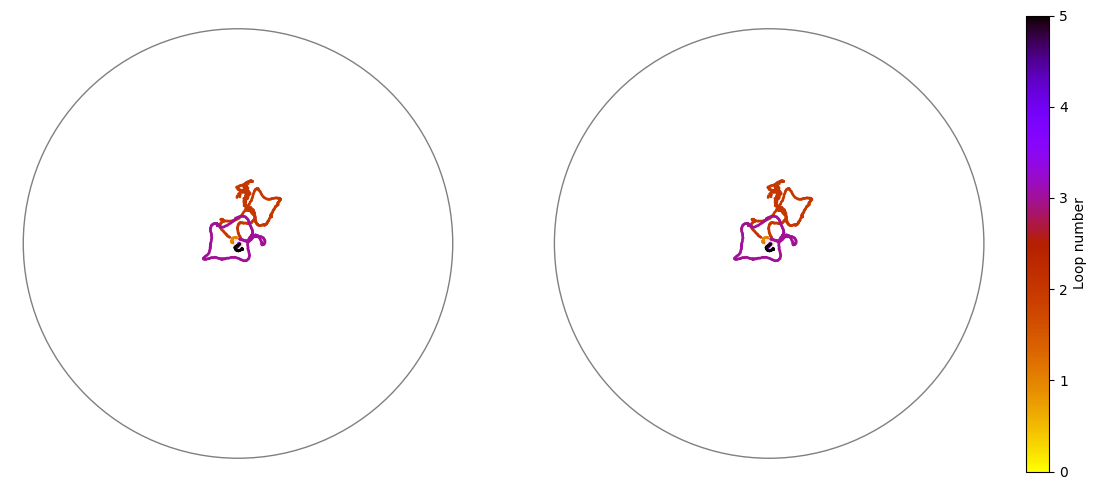

In [26]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
example_genotype = 'Tmem63b'
plotDf = loopDf.query(f'genotype=="{example_genotype}" & flyid=="{flyID}"')
n = plotDf.loopN.unique()[-1]
N = 10
axs[0].scatter(plotDf.query('loopN <= {}'.format(N)).body_x.values, plotDf.query('loopN <= {}'.format(N)).body_y.values,s=1,
               c=plotDf.query('loopN <= {}'.format(N)).loopN.values,cmap=loopcmap, vmin=0, vmax=n) 
plotArenaAndFood(axs[0], foodRad=plotDf.food_r.values[0], arenaRad=plotDf.arenaRad.values[0],foodCol='firebrick')

cb = axs[1].scatter(plotDf.body_x.values,plotDf.body_y.values,s=1,c=plotDf.loopN.values,cmap=loopcmap,vmin=0, vmax=n) 
plotArenaAndFood(axs[1], foodRad=plotDf.food_r.values[0], arenaRad=plotDf.arenaRad.values[0],foodCol='firebrick')
plt.colorbar(cb,label='Loop number')
fig.tight_layout()
fig.savefig(op.join(plotDir,f'loopIllustration_{flyID}_Fig6B.pdf'), dpi=300)

Tmem63
20
Tmem63b
21
Tmem63b_x_CSMH
21


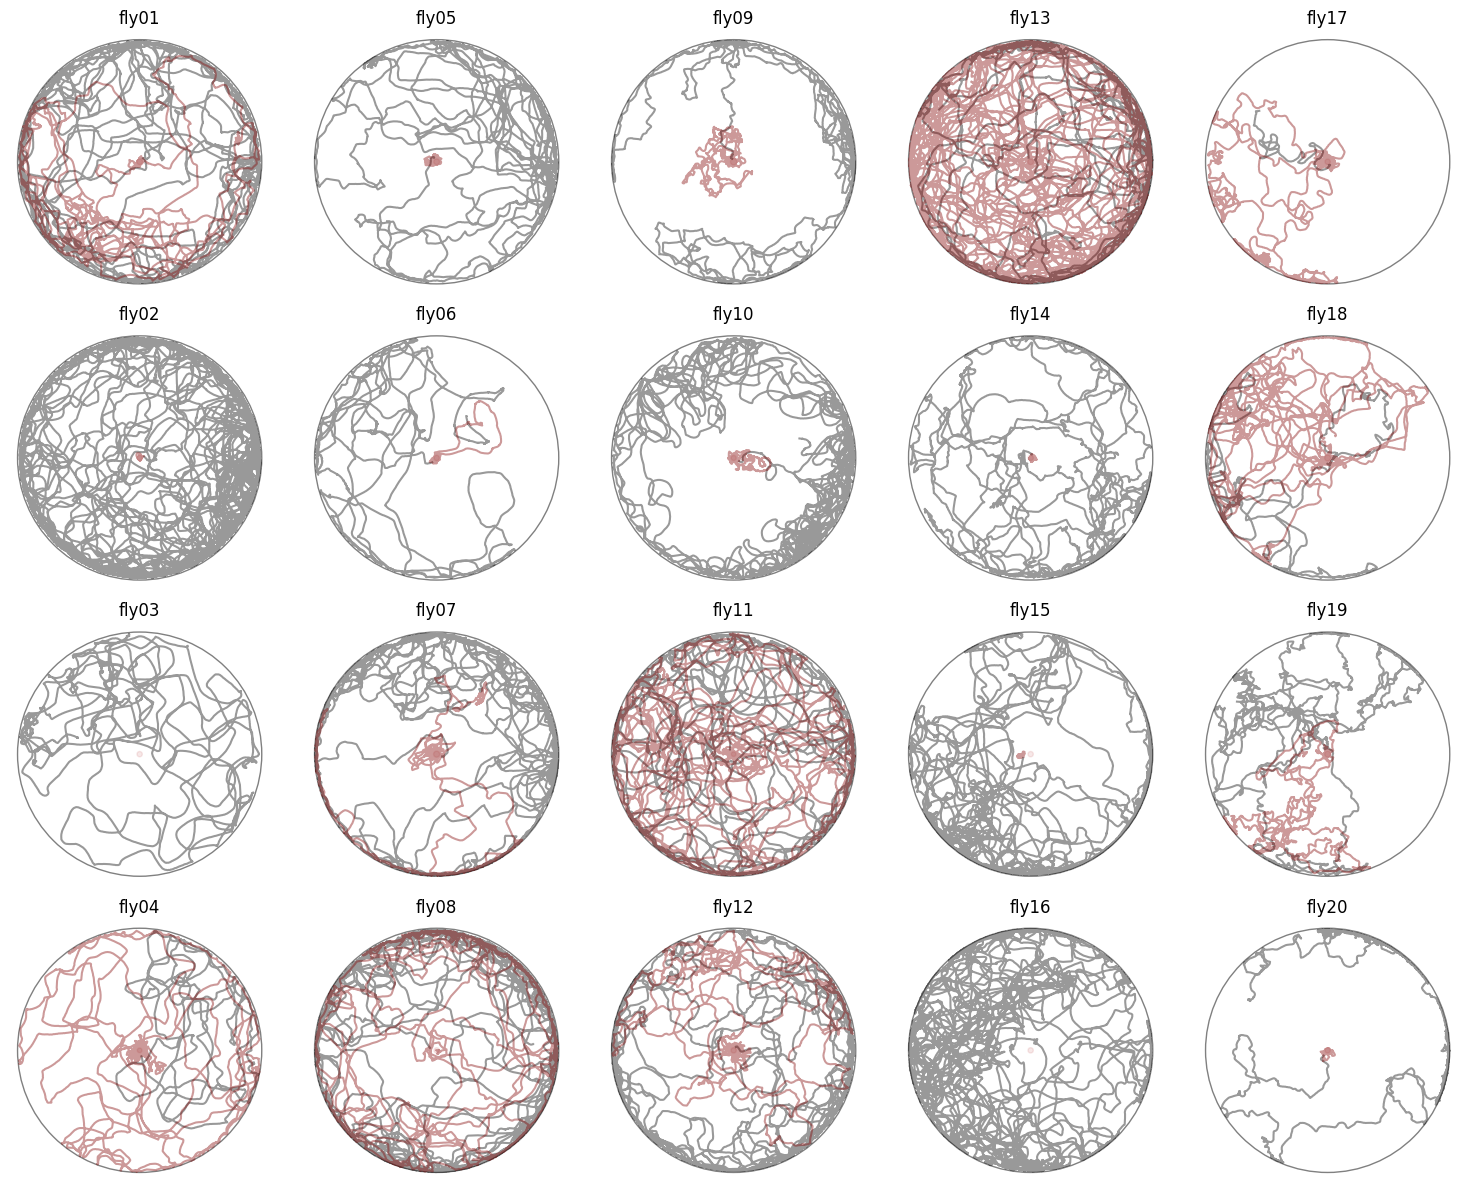

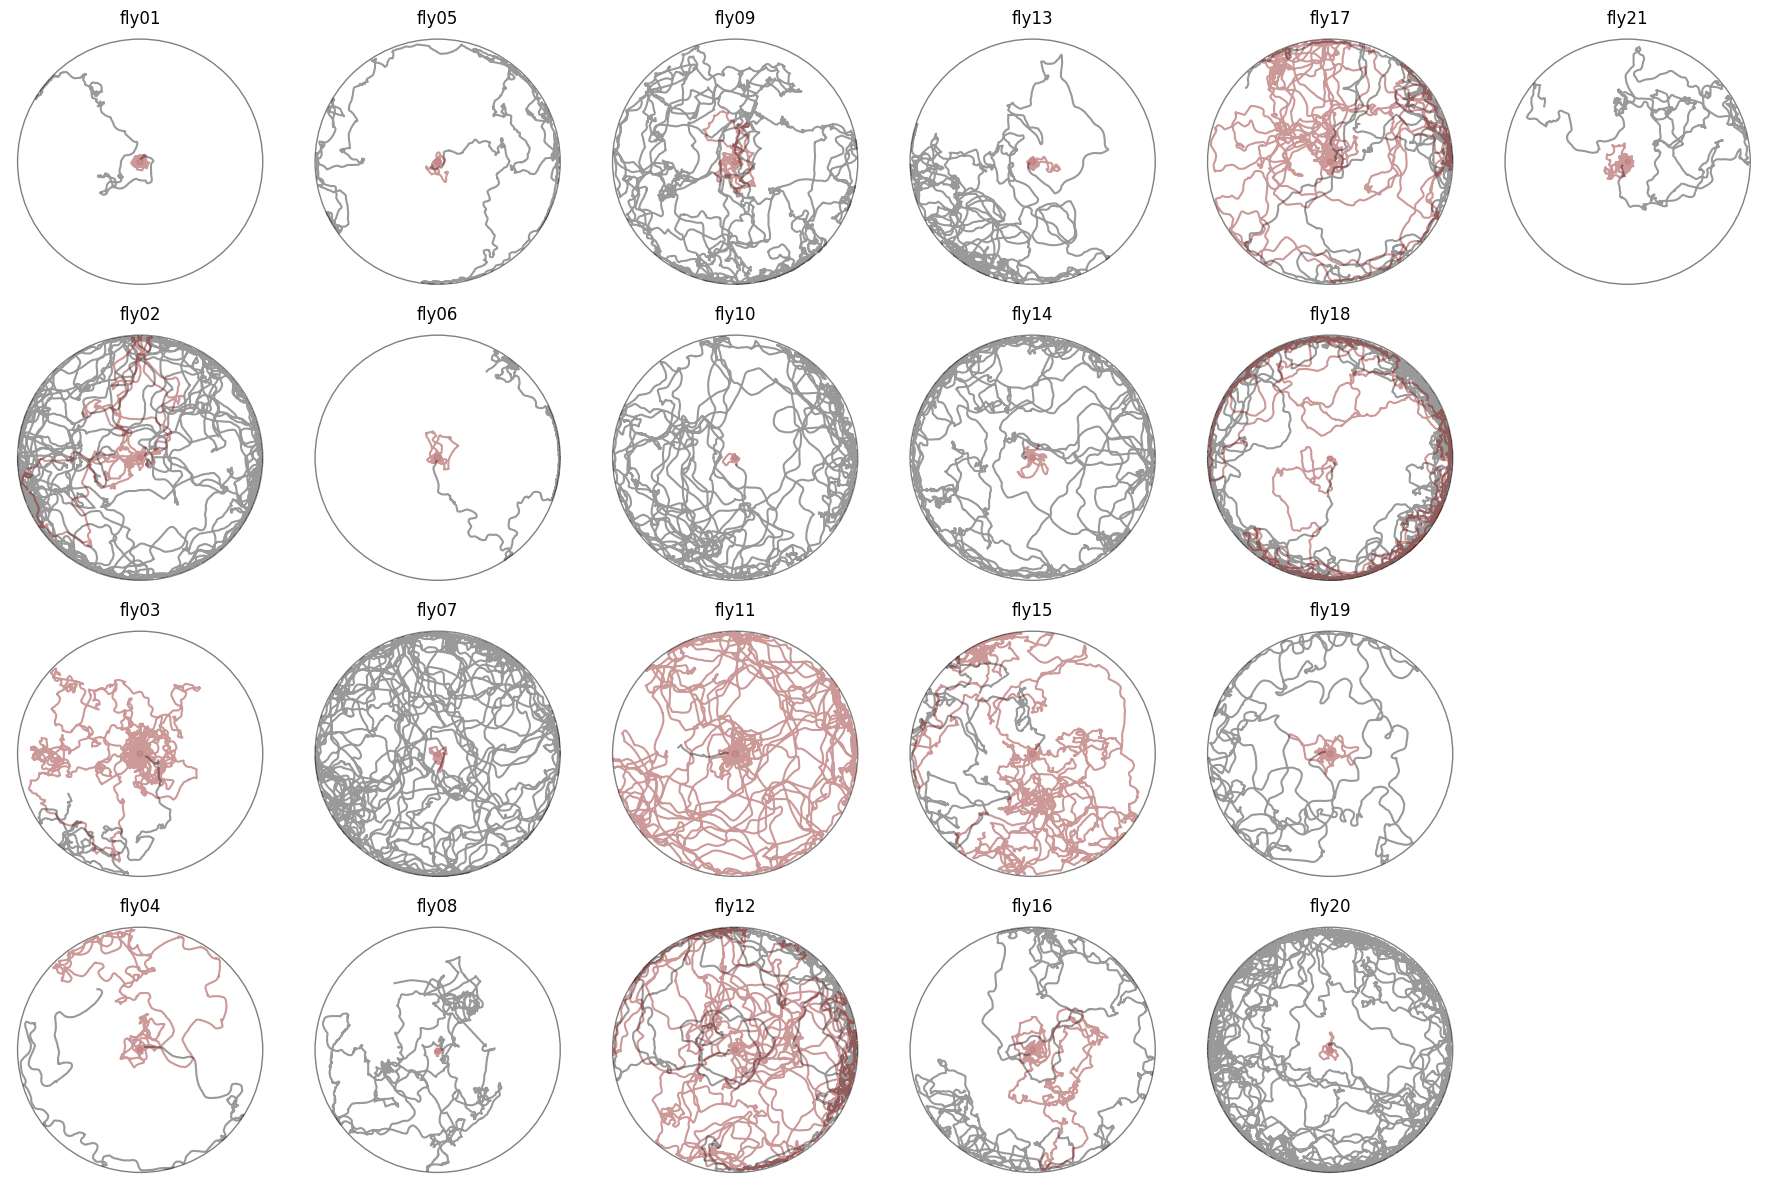

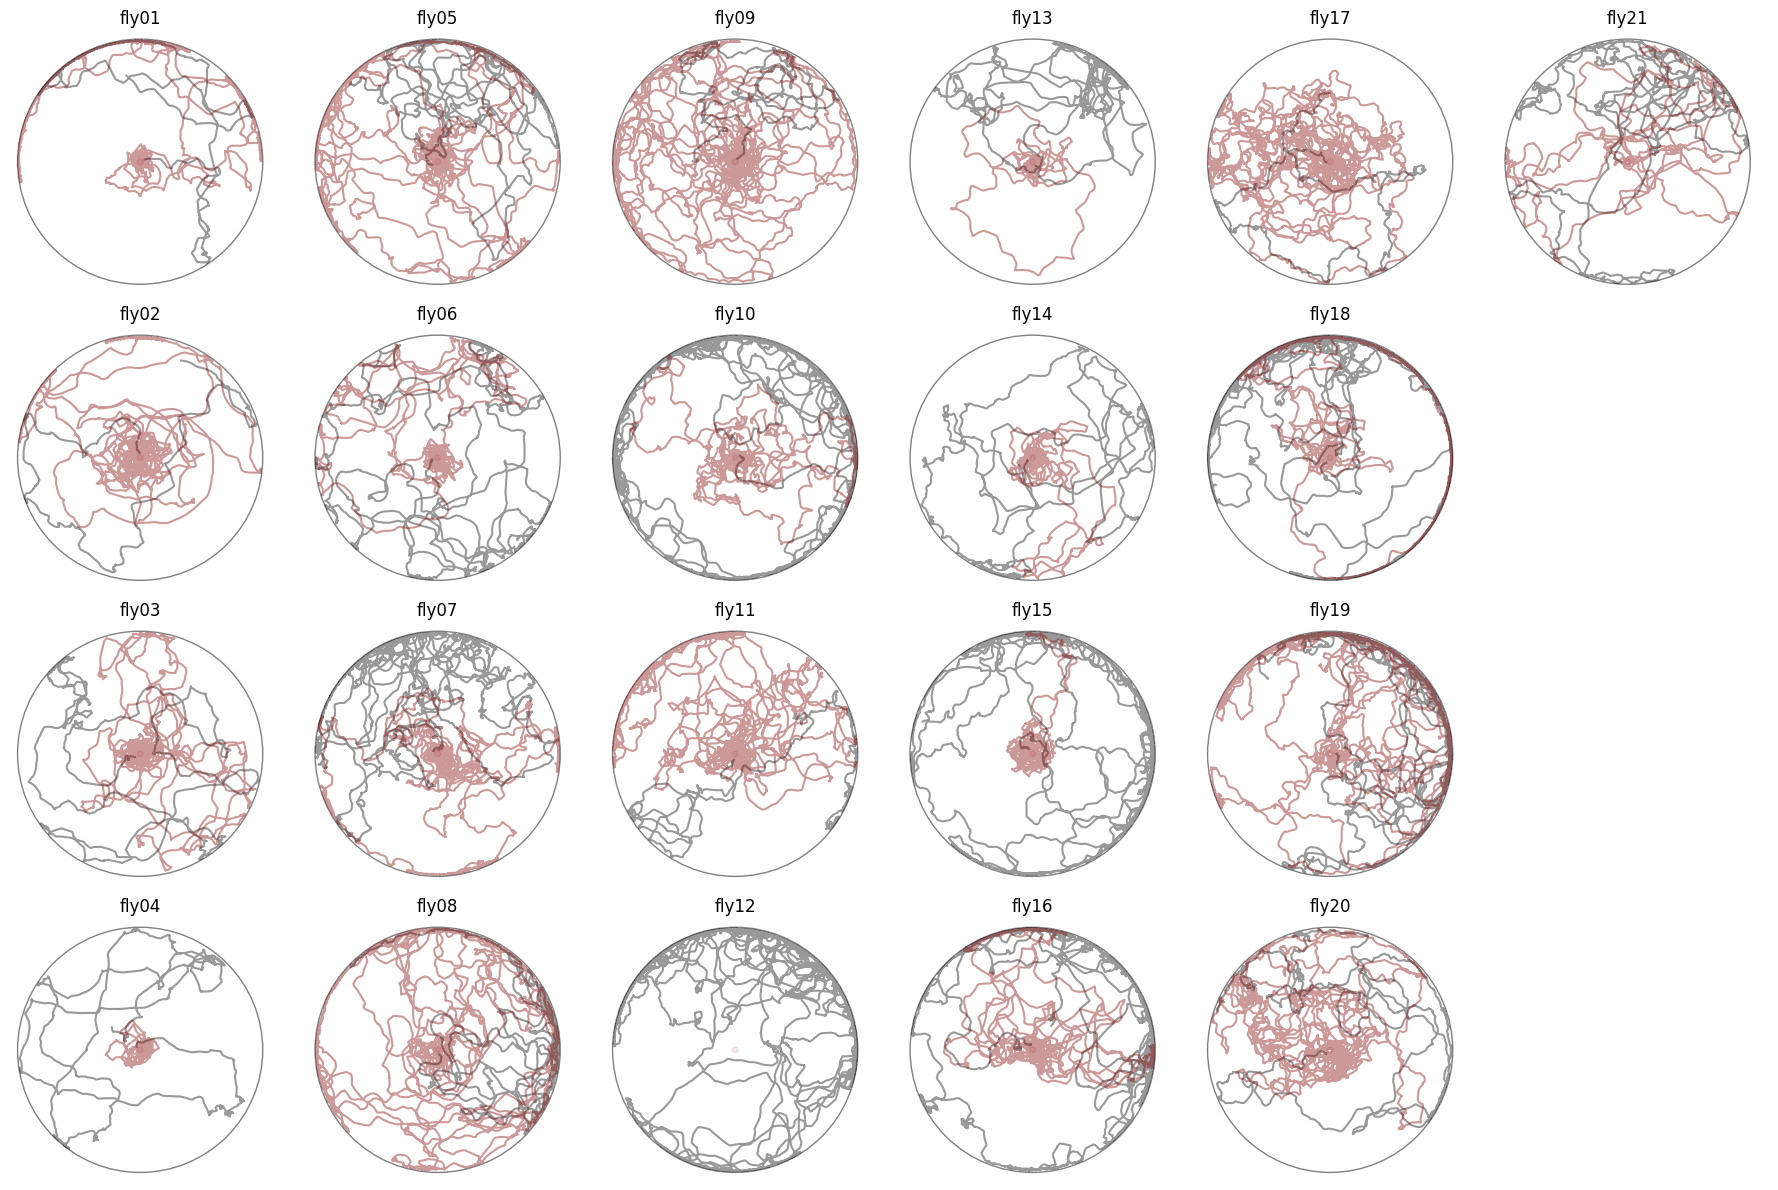

In [28]:
conditions = list(np.unique(datDf.condition.values))
for genotype in genotypes[2:]:
    print(genotype)
    cflies = datDf.query(f'genotype=="{genotype}"').flyid.unique()
    nflies = len(cflies)
    print(nflies)

    nrows = 4
    fig, axs = plt.subplots(nrows,int(np.ceil(nflies/nrows)),figsize=(3*np.ceil(nflies/nrows),3*nrows))

    for f, fly in enumerate(cflies):
        i = f%nrows
        j = int(f/nrows)
        flyDf = datDf.query(f'genotype=="{genotype}" & flyid=="{fly}"')
        
        try:
            firstFood = np.where(flyDf.segment.values == 1)[0][0]
        except IndexError:
            firstFood = -1
        axs[i,j].plot(flyDf.body_x.values[:firstFood], flyDf.body_y.values[:firstFood],color='k', alpha=0.4)
        axs[i,j].plot(flyDf.body_x.values[firstFood:], flyDf.body_y.values[firstFood:],color='maroon', alpha=0.4)
        plotArenaAndFood(axs[i,j], foodRad=flyDf.food_r.values[0], arenaRad=flyDf.arenaRad.values[0],foodCol='firebrick')
        axs[i,j].set_title(fly)
    for i in range(nrows):
        for ax in axs[i,:]: ax.axis('off')
    fig.tight_layout()

    fig.savefig(op.join(plotDir, f'trajectoryIllustration_{genotype}_DataS1.pdf'), dpi=300)

## Compute statistics on loops

#### Return (ratio) analysis

In [29]:
distDf = pd.DataFrame(columns = ['condition','flyid','maxDistRange','loopCount','returnratio'])
for genotype in genotypes:
    conddf = loopdepStats.query(f'genotype == "{genotype}"')
    flies = list(conddf.flyid.unique())
    for fly in flies:
        for r in myDistBins[1:]: #[1:]
            flydf = conddf.query(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            #print(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            if len(flydf) == 0:
                tmp = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'loopCount':[0]})
            else:
                tmp = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']].rename(columns={'maxDist':'loopCount'})
            tmp['maxDistRange'] = r
            
            flydf = conddf.query('segment == 4 & maxDist >= {} & flyid =="{}"'.format(r, fly))
            if len(flydf) == 0:
                tmp2 = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'nDepartures':[0]})
            else:
                tmp2 = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']]
            tmp = (pd.merge(tmp, tmp2, on=['genotype','flyid'])).rename(columns={'maxDist':'nDepartures'})
            tmp['allsegs'] = tmp.nDepartures + tmp.loopCount
            tmp = tmp[(tmp.allsegs > 0)]
            tmp['returnratio'] = tmp.loopCount.values/(tmp.loopCount.values + tmp.nDepartures.values)
            distDf = pd.concat([distDf,tmp])

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/289426696.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distDf = pd.concat([distDf,tmp])


In [30]:
distDf_farClose = pd.DataFrame(columns = ['condition','flyid','maxDistRange','loopCount','returnratio'])
for genotype in genotypes:
    conddf = loopdepStats.query(f'genotype == "{genotype}"')
    flies = list(conddf.flyid.unique())
    for fly in flies:
        for r in myDistBins_farClose[:-1]: #returns for everything >0 and everything > 20
            flydf = conddf.query(f'segment == 2 & maxDist >= {r} & flyid =="{fly}"')
            if len(flydf) == 0:
                tmp = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'loopCount':[0]})
            else:
                tmp = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']].rename(columns={'maxDist':'loopCount'})
            tmp['maxDistRange'] = r
            
            flydf = conddf.query('segment == 4 & maxDist >= {} & flyid =="{}"'.format(r, fly))
            if len(flydf) == 0:
                tmp2 = pd.DataFrame.from_dict({'genotype': [genotype], 'flyid':[fly], 'nDepartures':[0]})
            else:
                tmp2 = pd.DataFrame(flydf.groupby(['genotype','flyid']).count().to_records())[['genotype','flyid','maxDist']]
            tmp = (pd.merge(tmp, tmp2, on=['genotype','flyid'])).rename(columns={'maxDist':'nDepartures'})
            tmp['allsegs'] = tmp.nDepartures + tmp.loopCount
            tmp = tmp[(tmp.allsegs > 0)]
            tmp['returnratio'] = tmp.loopCount.values/(tmp.loopCount.values + tmp.nDepartures.values)
            distDf_farClose = pd.concat([distDf_farClose,tmp])

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/1014859126.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distDf_farClose = pd.concat([distDf_farClose,tmp])


<a id='fig-6c'></a>
## Fig. 6C - Boxplot of return ratios as a function of maximum distance from food range

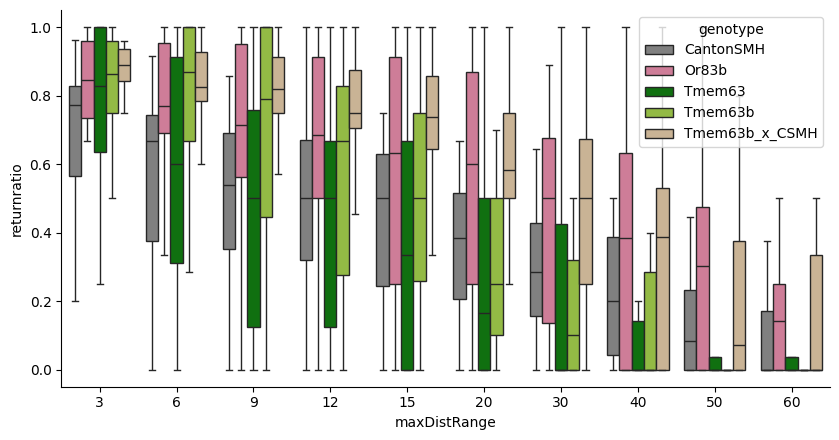

In [31]:
fig, axs = plt.subplots(1,1,figsize=(1+1.5*len(genotypes),4.5))
sns.boxplot(x='maxDistRange', y='returnratio', hue='genotype', data=distDf, showfliers = False, ax=axs, palette=pal, hue_order=genotypes)
myAxisTheme(axs)
fig.tight_layout()
fig.savefig(op.join(plotDir,'loopAndDepartureStatsVsCumDist_simpleGroupComparison_Fig6C.pdf'), dpi=300)

<a id='fig-s6h'></a>
## Fig. S6H - Boxplot of return ratios for close (< 20 mm) and far excursions (>= 20 mm)

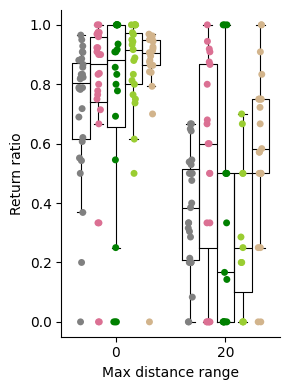

In [32]:
fig, axs = plt.subplots(1,1,figsize=(1+.4*len(genotypes),4))
sns.stripplot(x='maxDistRange', y='returnratio', hue='genotype', data=distDf_farClose, palette=pal, hue_order=genotypes, dodge=True, ax=axs, legend=False)
sns.boxplot(x='maxDistRange', y='returnratio', hue='genotype', data=distDf_farClose, showfliers = False, dodge=True, legend=False,fill=False, fliersize=0, width=0.8)
plt.setp(axs.lines, color='k',linewidth=0.8)
axs.set_xlabel('Max distance range')
axs.set_ylabel('Return ratio')
myAxisTheme(axs)
fig.tight_layout()
fig.savefig(op.join(plotDir, 'returnRatioCloseFar_FigS6H.pdf'), dpi=300)

#### TODO: Add stats

<a id='fig-6d'></a>
## Fig. 6D, S6A - Loop statistics boxplots

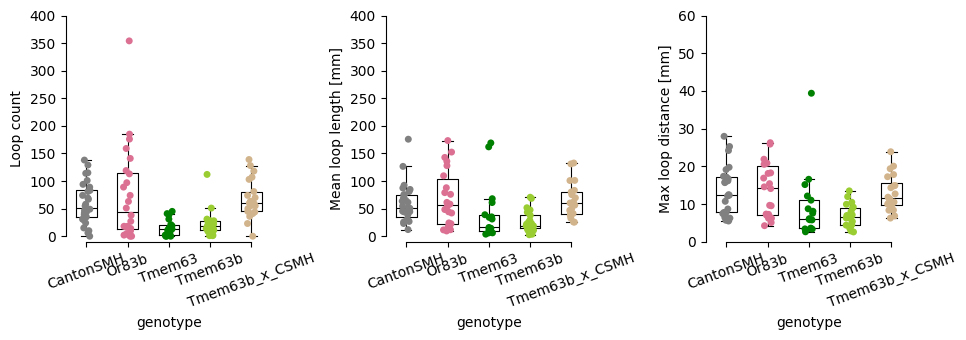

In [33]:
absLoopCount = distDf.groupby(['genotype','flyid'])[['loopCount']].sum().reset_index()
myfigsize=(.65*len(genotypes)*3,3.5)
fig, axs = plt.subplots(1,3,figsize=myfigsize)

sns.stripplot(x='genotype', y='loopCount', hue='genotype',palette=pal,data=absLoopCount,dodge=False, ax=axs[0], order=genotypes)
sns.boxplot(data=absLoopCount, x='genotype', y='loopCount', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[0], order=genotypes)
plt.setp(axs[0].lines, color='k',linewidth=0.8)
axs[0].set_ylim(-10,400)
axs[0].set_ylabel('Loop count')

meanLoopLen = pd.DataFrame(loopLenStats.groupby(['genotype','flyid']).mean('loop_length')['loop_length']).reset_index()

sns.stripplot(x='genotype', y='loop_length', hue='genotype',palette=pal,data=meanLoopLen,dodge=False,ax=axs[1], order=genotypes)
sns.boxplot(data=meanLoopLen, x='genotype', y='loop_length', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[1], order=genotypes)
plt.setp(axs[1].lines, color='k',linewidth=0.8)
axs[1].set_ylim(-10,400)
axs[1].set_ylabel('Mean loop length [mm]')

meanLoopLen = pd.DataFrame(loopLenStats.groupby(['genotype','condition', 'flyid']).mean('distance_patch_0')['distance_patch_0']).reset_index()

sns.stripplot(x='genotype', y='distance_patch_0', hue='genotype',palette=pal,data=meanLoopLen,dodge=False,ax=axs[2], order=genotypes)
sns.boxplot(data=meanLoopLen, x='genotype', y='distance_patch_0', hue='genotype', dodge=False, legend=False,fill=False, fliersize=0, width=0.5,ax=axs[2], order=genotypes)
plt.setp(axs[2].lines, color='k',linewidth=0.8)
axs[2].set_ylim(0,60)
axs[2].set_ylabel('Max loop distance [mm]')

for ax in axs:
    ax.set_xticks(range(len(genotypes)))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);

sns.despine(trim=True)
fig.tight_layout()
fig.savefig(op.join(plotDir,'loopStats_genotypeComparison_Fig6D-FigS6A.pdf'), dpi=300)

<a id='fig-6e'></a>
## Fig. 6E - Histogram and KDE fits of loop length distribution

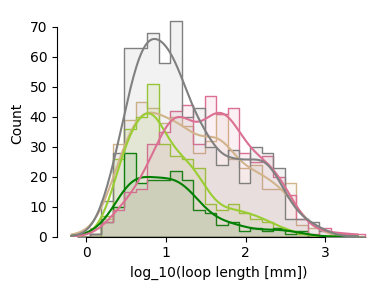

In [34]:
tmp = loopLenStats[['condition','genotype','flyid','loopN','loop_length']]
tmp['log_loop_length'] = np.log10(tmp['loop_length'])

fig, axs = plt.subplots(1,1,figsize=(4,3))
sns.histplot(ax=axs, data=tmp, x='log_loop_length', hue='genotype', bins=25, binrange=(-.1,3.5), element="step", fill=True, alpha=0.1,
             palette=pal,kde=True, legend=False)
axs.set_xlabel('log_10(loop length [mm])')
sns.despine(trim=True)
fig.tight_layout()
fig.savefig(op.join(plotDir, 'loopStats_loopLenDistribution_Fig6E.pdf'), dpi=300)

<a id='fig-s6g'></a>
## Fig. S6G - Regression analysis of loop scaling

CantonSMH
n=24
                            OLS Regression Results                            
Dep. Variable:               log_dist   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     49.54
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           6.27e-12
Time:                        15:35:32   Log-Likelihood:                -254.63
No. Observations:                 514   AIC:                             513.3
Df Residuals:                     512   BIC:                             521.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6145      0.035     

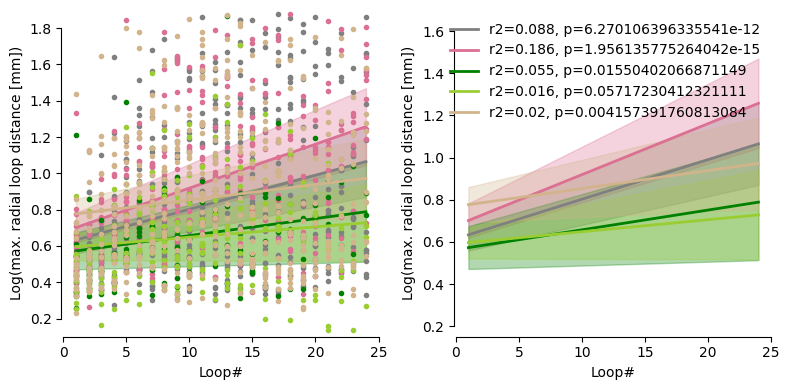

In [36]:
import statsmodels.formula.api as smf
fig, axs = plt.subplots(1,2, figsize=(8,4))    

for g, genotype in enumerate(genotypes):
    print(genotype)
    statsDf = loopLenStats.query(f'genotype == "{genotype}" & loopN < 25')[['flyid','loopN','distance_patch_0']]
    statsDf['log_dist'] = np.log10(statsDf.distance_patch_0)
    cts = statsDf.groupby('flyid').count().reset_index()
    slctflies = list(cts.query('loopN >= 10').flyid.values)
    print(f'n={len(slctflies)}')
    statsDf = statsDf.query(f'flyid in {slctflies}')

    axs[0].plot(statsDf.loopN, statsDf.log_dist,'.',color=pal[genotype])
    model = smf.ols(formula='log_dist~loopN', data=statsDf).fit()
    p = model.params
    x = np.arange(1, 25)   
    civ = model.conf_int(alpha=0.05)
    # plot regression line on the same axes, set x-axis limits
    axs[0].plot(x, p.Intercept + p.loopN*x,linewidth=2, color=pal[genotype], label=f'r2={round(model.rsquared,3)}, p={model.pvalues.loopN}')
    axs[0].fill_between(x, civ[0].Intercept + civ[0].loopN*x, civ[1].Intercept + civ[1].loopN*x,alpha=0.3,color=pal[genotype], label='')

    axs[1].plot(x, p.Intercept + p.loopN*x,linewidth=2, color=pal[genotype], label=f'r2={round(model.rsquared,3)}, p={model.pvalues.loopN}')
    axs[1].fill_between(x, civ[0].Intercept + civ[0].loopN*x, civ[1].Intercept + civ[1].loopN*x,alpha=0.3,color=pal[genotype], label='')

    print(model.summary())
    print('\n')
    
axs[0].set_ylim(0.1,1.9)
axs[1].set_ylim(0.15,1.7)
axs[1].legend(frameon=False)
for ax in axs:
    ax.set_xlabel('Loop#')
    ax.set_ylabel('Log(max. radial loop distance [mm])')
    sns.despine(trim=True, ax=ax)
fig.tight_layout()
fig.savefig(op.join(plotDir, 'loopscaling_groupComparison_linearReg_FigS6G.pdf'), dpi=300)

<a id='fig-6f'></a>
## Fig. 6F - First visit latency

In [37]:
maindir = '/Users/golddenn/Dropbox/LocalSearchData/data' ### TODO: change this to data repo
files = ['JR_Or83b_single_dark_5ul_perframe_0-125M_24hr',
         'JR_Tmem63_single_dark_5ul_perframe_0-125M_24hr',
         'JR_Tmem63b_single_dark_5ul_perframe_0-125M_24hr',
         'JR_Tmem63bxCSMH_single_dark_5ul_perframe_0-125M_24hr',
         'JR_CantonSMH_single_dark_5ul_perframe_0-125M_24hr',
        ]
labels = ['Or83b', 'Tmem63[2]', 'Tmem63[1]', 'Tmem63[1]xCS', 'Canton-S']

dfs=[]
for each, l in tqdm(zip(files, labels), total=len(labels), desc='Loading feather files'):
    filepath = op.join(maindir, f'{each}.feather')
    df = pd.read_feather(filepath)
    df['label'] = l
    dfs.append(df[['fly', 'label', 'time', 'ethogram']])
df = pd.concat(dfs)
print(df)

Loading feather files:   0%|          | 0/5 [00:00<?, ?it/s]

                                                       fly     label  \
0        bias_video_cam_0_date_2019_06_10_time_18_18_00...     Or83b   
1        bias_video_cam_0_date_2019_06_10_time_18_18_00...     Or83b   
2        bias_video_cam_0_date_2019_06_10_time_18_18_00...     Or83b   
3        bias_video_cam_0_date_2019_06_10_time_18_18_00...     Or83b   
4        bias_video_cam_0_date_2019_06_10_time_18_18_00...     Or83b   
...                                                    ...       ...   
1811297  bias_video_cam_0_date_2019_10_17_time_11_21_00...  Canton-S   
1811298  bias_video_cam_0_date_2019_10_17_time_11_21_00...  Canton-S   
1811299  bias_video_cam_0_date_2019_10_17_time_11_21_00...  Canton-S   
1811300  bias_video_cam_0_date_2019_10_17_time_11_21_00...  Canton-S   
1811301  bias_video_cam_0_date_2019_10_17_time_11_21_00...  Canton-S   

                time  ethogram  
0           0.000000       1.0  
1           0.041694       1.0  
2           0.083388       1.0  
3  

label                                                fly  \
0     Canton-S  bias_video_cam_0_date_2019_06_05_time_18_12_19...   
1     Canton-S  bias_video_cam_0_date_2019_06_06_time_17_56_10...   
2     Canton-S  bias_video_cam_0_date_2019_06_13_time_19_38_52...   
3     Canton-S  bias_video_cam_0_date_2019_06_19_time_15_45_36...   
4     Canton-S  bias_video_cam_0_date_2019_06_21_time_10_55_39...   
..         ...                                                ...   
106  Tmem63[2]  bias_video_cam_0_date_2023_10_10_time_11_06_43...   
107  Tmem63[2]  bias_video_cam_0_date_2023_10_11_time_09_43_52...   
108  Tmem63[2]  bias_video_cam_0_date_2023_10_12_time_09_24_53...   
109  Tmem63[2]  bias_video_cam_0_date_2023_10_12_time_10_26_18...   
110  Tmem63[2]  bias_video_cam_0_date_2023_10_12_time_11_16_55...   

     first_time_of_feeding  
0                 9.005858  
1               263.212844  
2               260.752941  
3               350.644704  
4               531.262351  
..                     ...  
106            2542.064791  
107              15.468363  
108             413.267980  
109             620.110373  
110             664.097226  

[111 rows x 3 columns]

Canton-S Or83b 0.8331841703348378 -0.21061953138798983
Canton-S Tmem63[1] 0.0864242511545085 -1.7145691375685115
Canton-S Tmem63[1]xCS 0.12659281191432903 -1.52767676433737
Canton-S Tmem63[2] 0.0007181171636077519 -3.382567161370324
Or83b Tmem63[1] 0.15491015044730932 -1.422400043763526
Or83b Tmem63[1]xCS 0.2534205678251751 -1.1420804814403214
Or83b Tmem63[2] 0.014801018689134231 -2.437211521390788
Tmem63[1] Tmem63[1]xCS 0.5838824207703652 0.5477225575051661
Tmem63[1] Tmem63[2] 0.3104944343172349 -1.01418510567422
Tmem63[1]xCS Tmem63[2] 0.026291395028860274 -2.221880315577807


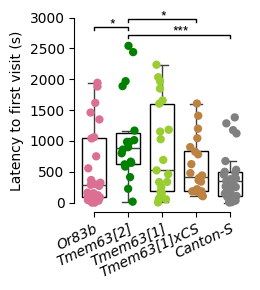

In [38]:
# 1) First time of feeding per fly and condition
first_feeding = (
    df.loc[df['ethogram'].eq(3)]
      .sort_values(['label', 'fly', 'time'])
      .groupby(['label', 'fly'], as_index=False)['time']
      .min()
      .rename(columns={'time': 'first_time_of_feeding'})
)
display(first_feeding)

# 2) Define colors per condition (replace with your own)
# Example: explicit colors per label
palette = {
    'Canton-S':  'grey',
    'Or83b':     'palevioletred',
    'Tmem63[2]': 'green',
    'Tmem63[1]': 'yellowgreen',
    'Tmem63[1]xCS': '#bc8242',
}
# If some labels are missing from the dict, Seaborn will fall back to default colors.

# 3) Plot: boxplot with overlaid stripplot
sfac = 0.3
plt.figure(figsize=(sfac*9, sfac*10))

ax = sns.boxplot(
    data=first_feeding,
    x='label',
    y='first_time_of_feeding',
    order= labels,
    boxprops={'facecolor': 'none', 'edgecolor': 'black'},
    width=0.7,
    showfliers=False
)

sns.stripplot(
    data=first_feeding,
    x='label',
    y='first_time_of_feeding',
    hue='label',
    order= labels,
    palette=palette,
    size=6, 
    jitter=0.2, 
    dodge=False,
    edgecolor='none',
    linewidth=0.5
)

# Right-align and italicize xticklabels
plt.setp(
    ax.get_xticklabels(),
    ha='right',            # anchor to the right
    rotation=25,           # (optional) angled labels
    rotation_mode='anchor',
    fontstyle='italic'     # italic text
)

from itertools import combinations
from scipy.stats import mannwhitneyu,ranksums  # Wilcoxon rank-sum equivalent in SciPy

# 4) Pairwise Wilcoxon rank-sum tests (Mann–Whitney U) ---
pairs = list(combinations(first_feeding['label'].unique(), 2))

results = []
for g1, g2 in pairs:
    x1 = first_feeding.loc[first_feeding['label'] == g1, 'first_time_of_feeding']
    x2 = first_feeding.loc[first_feeding['label'] == g2, 'first_time_of_feeding']
    stat, p = mannwhitneyu(x1, x2)
    stat, p1 = ranksums(x1, x2)
    results.append({'group1': g1, 'group2': g2, 'p': p})
    print(g1, g2, p1, stat)
        

stats_df = pd.DataFrame(results)

# keep only significant comparisons
alpha = 0.05
sig_stats = stats_df[stats_df['p'] < alpha].sort_values('p')


def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# map labels to x positions
xticks = ax.get_xticks()
xticklabels = [t.get_text() for t in ax.get_xticklabels()]
label_to_x = {lab: x for lab, x in zip(xticklabels, xticks)}

y_max = first_feeding['first_time_of_feeding'].max()
h = 0.05 * y_max if y_max > 0 else 1  # vertical step between annotation lines
line_height = 0.02 * y_max           # little bump height for the line

for i, row in enumerate(sig_stats.itertuples(index=False)):
    x1 = label_to_x[row.group1]
    x2 = label_to_x[row.group2]
    y = y_max + h * (i + 1)

    # draw the line
    ax.plot(
        [x1, x1, x2, x2],
        [y, y + line_height, y + line_height, y],
        lw=1,
        c='black'
    )

    # add stars
    ax.text(
        (x1 + x2) / 2,
        y + line_height-80,
        p_to_stars(row.p),
        ha='center',
        va='bottom',
        fontstyle='italic',
        fontname='Arial'
    )



ax.set_xlabel('')
ax.set_ylabel('Latency to first visit (s)')
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(op.join(plotDir,'latency.pdf'), dpi=300)

### Calculate further stats

In [39]:
loopDistCt = pd.DataFrame(loopdepStats.query('segment == 2').groupby(['condition','flyid','maxDistBin_uneven']).count().to_records())\
                [['condition','flyid','maxDistBin_uneven','segment']]
depDistCt = pd.DataFrame(loopdepStats.query('segment == 4').groupby(['condition','flyid','maxDistBin_uneven']).count().to_records())\
                [['condition','flyid','maxDistBin_uneven','segment']]
DistCt = (pd.merge(loopDistCt, depDistCt, on=['condition','flyid','maxDistBin_uneven'])).rename(columns={'segment_x':'loopCount','segment_y':'departureCount'})
DistCt['returnratio'] = DistCt.loopCount.values/(DistCt.loopCount.values+DistCt.departureCount.values)

loopDistCt_farClose = pd.DataFrame(loopdepStats.query('segment == 2').groupby(['condition','flyid','maxDistBin_farClose']).count().to_records())\
                [['condition','flyid','maxDistBin_farClose','segment']]
depDistCt_farClose = pd.DataFrame(loopdepStats.query('segment == 4').groupby(['condition','flyid','maxDistBin_farClose']).count().to_records())\
                [['condition','flyid','maxDistBin_farClose','segment']]
DistCt_farClose = (pd.merge(loopDistCt_farClose, depDistCt_farClose, on=['condition','flyid','maxDistBin_farClose'])).rename(columns={'segment_x':'loopCount','segment_y':'departureCount'})
DistCt_farClose['returnratio'] = DistCt_farClose.loopCount.values/(DistCt_farClose.loopCount.values+DistCt_farClose.departureCount.values)

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/927610227.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loopDistCt = pd.DataFrame(loopdepStats.query('segment == 2').groupby(['condition','flyid','maxDistBin_uneven']).count().to_records())\
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/927610227.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  depDistCt = pd.DataFrame(loopdepStats.query('segment == 4').groupby(['condition','flyid','maxDistBin_uneven']).count().to_records())\
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/927610227.py:6: RuntimeWarni

In [40]:
loopFedCt = pd.DataFrame(loopdepStats.query('segment == 2').groupby(['condition','flyid','feedingBin']).count().to_records())\
                [['condition','flyid','feedingBin','segment']]
depFedCt = pd.DataFrame(loopdepStats.query('segment == 4').groupby(['condition','flyid','feedingBin']).count().to_records())\
                [['condition','flyid','feedingBin','segment']]
FedCt = (pd.merge(loopFedCt, depFedCt, on=['condition','flyid','feedingBin'])).rename(columns={'segment_x':'loopCount','segment_y':'departureCount'})
FedCt['returnratio'] = FedCt.loopCount.values/(FedCt.loopCount.values+FedCt.departureCount.values)

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/2979648140.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loopFedCt = pd.DataFrame(loopdepStats.query('segment == 2').groupby(['condition','flyid','feedingBin']).count().to_records())\
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/2979648140.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  depFedCt = pd.DataFrame(loopdepStats.query('segment == 4').groupby(['condition','flyid','feedingBin']).count().to_records())\
/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/2979648140.py:6: RuntimeWarning: invalid v

<a id='fig-6g'></a>
## Fig. 6G - Path length tortuosity by maximum distance to food range

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/200095161.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plotDf = plotDf.groupby(['condition','flyid','genotype','maxDistBin_farClose'])['pathLengthDistanceRatio'].median().reset_index()


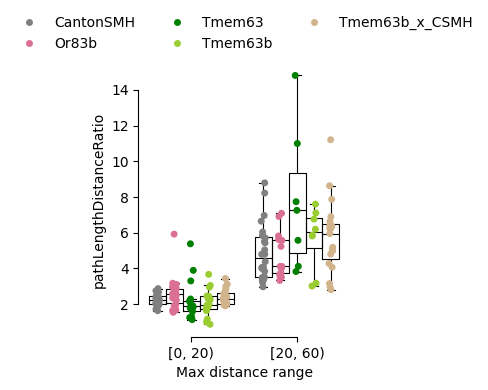

In [41]:
plotDf = loopdepStats.query('segment == 2 & condition in ["0-125M_24hr"]').reset_index()
plotDf = plotDf.groupby(['condition','flyid','genotype','maxDistBin_farClose'])['pathLengthDistanceRatio'].median().reset_index()
#plotDf.to_csv(plotGroupDir+sep+savename+'_loopLenVsLoopDistancetoLengthRatio_genotypeComparison_24hsugar_closeFar.csv')

fig, axs = plt.subplots(1,1,figsize = (0.8*len(genotypes),4))
sns.stripplot(x='maxDistBin_farClose', y='pathLengthDistanceRatio', hue='genotype', palette=pal,data=plotDf,dodge=True,ax=axs)
sns.boxplot(data=plotDf, x='maxDistBin_farClose', y='pathLengthDistanceRatio', hue='genotype', dodge=True, legend=False,fill=False, fliersize=0, width=0.8,ax=axs)
plt.setp(axs.lines, color='k',linewidth=0.8)
axs.set_xlabel('Max distance range')
sns.move_legend(axs, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
sns.despine(trim=True)
fig.tight_layout()
fig.savefig(op.join(plotDir, 'loopLenVsLoopDistancetoLengthRatio_genotypeComparison_Fig6G.pdf'), dpi=300)

#### TODO: Add stats

<a id='fig-s6b'></a>
## Fig. S6B-E - GMM fitting on trip length distributions

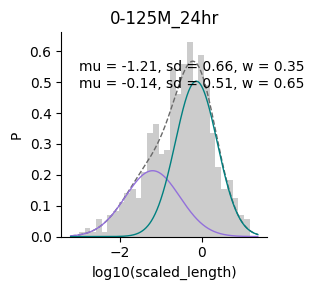

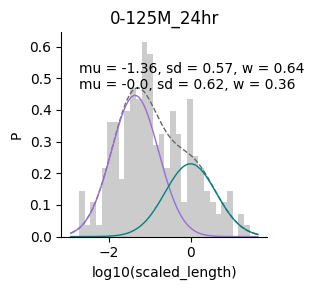

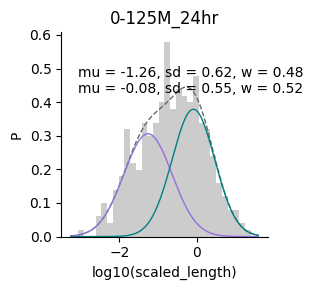

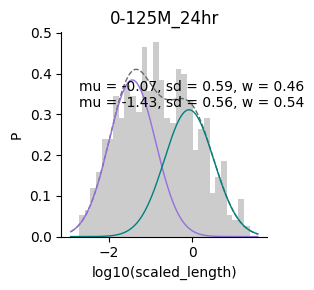

In [42]:
# 'Or83b', 'Tmem63', 'Tmem63b', 'Tmem63b_x_CSMH']
qOI = qOIs[qSlct]
fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "Or83b"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(op.join(plotDir, 'P_scaled_length_fitGMM_FigS6B.pdf'), dpi=300)

fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "Tmem63"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(op.join(plotDir, 'P_scaled_length_fitGMM_FigS6C.pdf'), dpi=300)

fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "Tmem63b"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(op.join(plotDir, 'P_scaled_length_fitGMM_FigS6D.pdf'), dpi=300)

fig, M_best = plot_trip_distribution_fit(per_trip_df.query('genotype == "Tmem63b_x_CSMH"'), qOI, condsOI, otherparams = fitparams, numbins = 30, 
                                 iflog = True, colwidth = 3, rowwidth = 3, alphaval = 0.4, linecols=list(trip_color.values()))
fig.tight_layout()
fig.savefig(op.join(plotDir, 'P_scaled_length_fitGMM_FigS6E.pdf'), dpi=300)

<a id='fig-s6f'></a>
## Fig. S6F - Probability of long trips

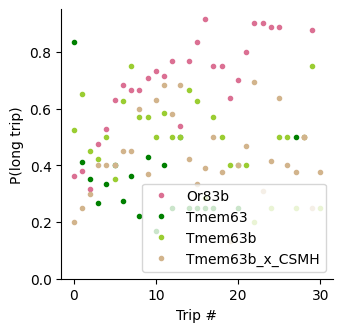

In [43]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))
conds2plot = conditions[0:3]
plot_df2 = per_trip_df.query(f'condition in {conds2plot}').reset_index(drop=True)
for g, genotype in enumerate(genotypes[1:]):
    tmp = plot_df2.query(f'trip_index <=30 & genotype == "{genotype}" & condition == "{condOI}"')[['trip_index','triptype','length']].groupby(['triptype','trip_index']).count().unstack()
    pLongTrip = (tmp.query('triptype == "long"').values/(tmp.query('triptype == "long"').values+tmp.query('triptype == "short"').values))[0]
    ax.plot(np.arange(0,len(pLongTrip)),pLongTrip,'.', color=pal[genotype], label=genotype)
    ax.set_xlabel('Trip #')
    ax.set_ylabel('P(long trip)')
    ax.set_ylim(0,.95)
    ax.legend()
    myAxisTheme(ax)
fig.savefig(op.join(plotDir, f'probabilityOfLongTrips_trvar-{qOIs[qSlct]}_FigS6F.pdf'), dpi=300)

## Generate distribution plots
To generate the plots for the "before food" and "after food" condition, change the 'visitTH' variable to ==0 -(-> before finding food spot) or >=1 (--> after finding food)

In [44]:
# extract data of interest
numbins = 30
criteria = {}
print(genotypes)
conditions = list(datDf.condition.unique())
print(conditions)

visitTH = '>=1' #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
if visitTH == '==0': postfix = 'beforefood'
else: postfix = 'afterfood'
print(postfix)

['CantonSMH', 'Or83b', 'Tmem63', 'Tmem63b', 'Tmem63b_x_CSMH']
['0-125M_24hr']
afterfood


<a id='fig-s6i'></a>
## Fig. S6I - Run length distribution

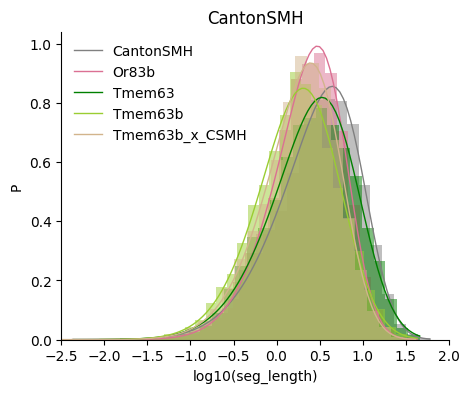

In [45]:
# extract data of interest
etho_state = [2] # 2: runs
qOI = 'seg_length'
iflogq = True
distOI = 'skewnorm'

dffitRunLenAll = pd.DataFrame()
fig, axs = plt.subplots(1,1,figsize=(5,4))
fittedparamsall = np.nan*np.ones((3,len(genotypes)))

for g, genotype in enumerate(genotypes):
    plotcol = pal[genotype]
    ax = axs
    querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
    querystring = querystring + f' & after_which_visit {visitTH}'
    perMoveSegDF_filt = perMoveSegDF.query(querystring)
    if len(perMoveSegDF_filt) == 0: 
        continue
    datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
    fittedparamsall[:,g] = fittedparams
    ax = plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol=plotcol,iflog = iflogq)

    dffitRunLen = pd.DataFrame(data=fittedparamsall.T, columns = ['a','loc','scale'])
    dffitRunLen['condition'] = conditions[0]
    dffitRunLen['genotype'] = genotype
    dffitRunLenAll = pd.concat([dffitRunLenAll,dffitRunLen])
dffitRunLenAll = dffitRunLenAll.reset_index(drop=True).dropna()
axs.legend(genotypes, frameon=False)
axs.set_xlim(-2.5,2)
myAxisTheme(axs)
ax.set_title(genotypes[0])
fig.savefig(op.join(plotDir, f'runLengthDistribution_{postfix}_FigS6I.pdf'), dpi=300)
#dffitRunLenAll

<a id='fig-s6j'></a>
## Fig. S6J - Turn size distribution

/opt/anaconda3/envs/foraging/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


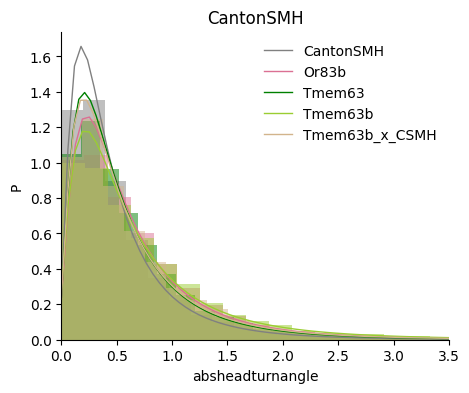

In [46]:
# extract data of interest
etho_state = [1] # 1: turns
qOI = 'absheadturnangle'
iflogq = False
distOI = 'lognorm'
xlims = (0,3.5) #0,3

dffitTurnAngAll = pd.DataFrame()
fittedparamsall = np.nan*np.ones((3,len(genotypes)))
fig, axs = plt.subplots(1,1,figsize=(5,4))

for g, genotype in enumerate(genotypes):
    plotcol = pal[genotype]
    ax = axs
    querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
    querystring = querystring + f' & after_which_visit {visitTH}'
    
    perMoveSegDF_filt = perMoveSegDF.query(querystring)
    if len(perMoveSegDF_filt) == 0: 
        continue
    datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
    fittedparamsall[:,g] = fittedparams
    ax = plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol=plotcol,iflog = iflogq)

    dffitTurnAng = pd.DataFrame(data=fittedparamsall.T, columns = ['s','loc','scale'])
    dffitTurnAng['condition'] = conditions[0]
    dffitTurnAng['genotype'] = genotype
    dffitTurnAngAll = pd.concat([dffitTurnAngAll,dffitTurnAng])
dffitTurnAngAll = dffitTurnAngAll.reset_index(drop=True).dropna()

axs.legend(genotypes, frameon=False)
axs.set_xlim(xlims)
myAxisTheme(axs)
ax.set_title(genotypes[0])
fig.savefig(op.join(plotDir, f'turnAngleDistribution_{postfix}_FigS6J.pdf'), dpi=300)
#dffitTurnAngAll

<a id='fig-s6k'></a>
## Fig. S6K - Turn radius distribution

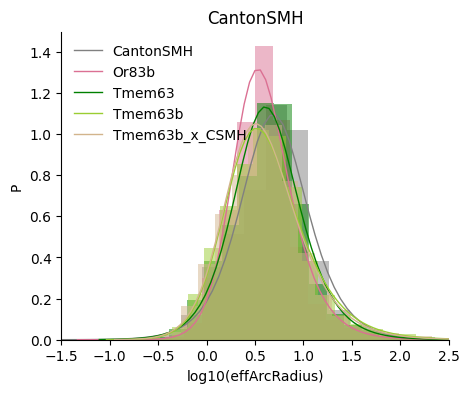

In [47]:
# extract data of interest
etho_state = [1] # 1: turns
qOI = 'effArcRadius'
iflogq = True
distOI = 'genlogistic'
xlims = (-1.5, 2.5)
dffitTurnRadAll = pd.DataFrame()
fittedparamsall = np.nan*np.ones((3,len(genotypes)))
fig, axs = plt.subplots(1,1,figsize=(5,4))

for g, genotype in enumerate(genotypes):
    plotcol = pal[genotype]
    ax = axs
    querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
        
    perMoveSegDF_filt = perMoveSegDF.query(querystring)
    if len(perMoveSegDF_filt) == 0: continue
    datavec, fittedparams, best_fit_line = getModelDistributionParams(perMoveSegDF_filt, qOI, criteria,fitdist = distOI,iflog = iflogq)
    fittedparamsall[:,g] = fittedparams
    ax = plotModelDistributionParams(ax, datavec, fittedparams, best_fit_line, condcol=plotcol,iflog = iflogq)

    dffitTurnRad = pd.DataFrame(data=fittedparamsall.T, columns = ['c','loc','scale'])
    dffitTurnRad['condition'] = conditions[0]
    dffitTurnRad['genotype'] = genotypes
    dffitTurnRadAll = pd.concat([dffitTurnRadAll,dffitTurnRad])
dffitTurnRadAll = dffitTurnRadAll.reset_index(drop=True)

axs.legend(genotypes, frameon=False)
axs.set_xlim(xlims)
myAxisTheme(axs)
ax.set_title(genotypes[0])
fig.savefig(op.join(plotDir, f'turnRadiusDistribution_{postfix}_FigS6K.pdf'), dpi=300)


<a id='fig-s6l'></a>
## Fig. S6L - Turn bias

CantonSMH
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "CantonSMH" & after_which_visit ==0& condition == "0-125M_24hr"
Or83b
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Or83b" & after_which_visit ==0& condition == "0-125M_24hr"
Tmem63
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Tmem63" & after_which_visit ==0& condition == "0-125M_24hr"
Tmem63b
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Tmem63b" & after_which_visit ==0& condition == "0-125M_24hr"
Tmem63b_x_CSMH
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Tmem63b_x_CSMH" & after_which_visit ==0& condition == "0-125M_24hr"
CantonSMH
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "CantonSMH" & after_which_visit >=1& condition == "0-125M_24hr"
Or83b
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Or83b" & after_which_visit >=1& condition == "0-125M_24hr"
Tmem63
seg_state in [2, 3, 4, 5] & etho_state == [1] & genotype == "Tmem63" & 

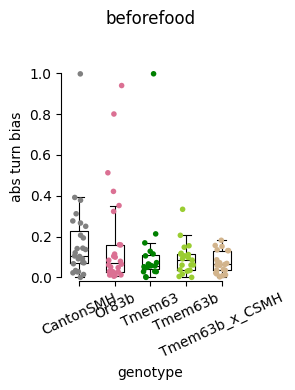

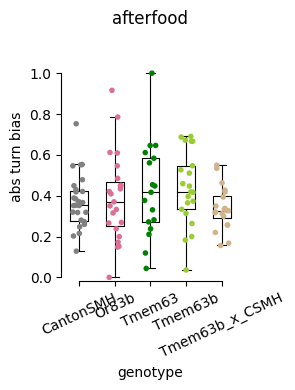

In [52]:
etho_state = [1] # turns

for i, visitTH in enumerate(['==0','>=1']): #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
    if visitTH == '==0': postfix = 'beforefood'
    else: postfix = 'afterfood'

    #itterate through genotypes to fetch correct data
    means_tmp = pd.DataFrame()
    counts_tmp = pd.DataFrame()
    for g, genotype in enumerate(genotypes):
        querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state} & genotype == "{genotype}"'
        querystring = querystring + f' & after_which_visit {visitTH}'
        if len(genotypes) > 1 :
            querystring = querystring + f'& condition == "{conditions[0]}"'
        print(genotype)
        print(querystring)
        means_tmp = pd.concat([means_tmp,perMoveSegDF.query(querystring)])
        counts_tmp = pd.concat([counts_tmp,perMoveSegDF.query(querystring)])
    
    keep_indices = ['genotype','condition','fly','after_which_visit']
    means = means_tmp.groupby(keep_indices)['ifCW'].mean().reset_index()
    counts = counts_tmp.groupby(keep_indices)['ifCW'].count().reset_index()
    perMoveSegDF_filt = pd.merge(means,counts,on=keep_indices)
    perMoveSegDF_filt = perMoveSegDF_filt.rename(columns={"ifCW_x": "ifCW", "ifCW_y": "turnCount"})
    #rescale turn bias
    perMoveSegDF_filt['ifCWplt'] = 2*(perMoveSegDF_filt.ifCW.values-0.5)
    perMoveSegDF_filt = perMoveSegDF_filt.query('turnCount >= 3')

    plotdf = perMoveSegDF_filt.copy()
    plotdf['abs_ifCW'] = np.abs(plotdf.ifCW.values -0.5)*2
    tmp = plotdf.groupby(['genotype','fly'])['abs_ifCW'].mean().reset_index()
    absTurnBiasMedians = tmp.groupby(['genotype'])[['abs_ifCW']].median().reset_index()
    plotdf.to_csv(op.join(plotDir, f'absturnBias_{postfix}.csv'), index=False)  

    fig, axs = plt.subplots(1,1,figsize=(3,4))
    tmp = plotdf.groupby(['genotype','fly'])['abs_ifCW'].mean().reset_index()
    sns.stripplot(tmp, x='genotype', y='abs_ifCW', hue='genotype', palette=pal, ax=axs, size=4, jitter=.2)
    sns.boxplot(tmp, x='genotype', y='abs_ifCW', dodge=False, legend=False,fill=False, fliersize=0, width=0.5)
    axs.set_xticks(range(len(plotdf['genotype'].unique()))) 
    plt.setp(axs.lines, color='k',linewidth=0.8)
    axs.set_xticklabels(axs.get_xticklabels(),rotation = 25);
    axs.set_ylabel('abs turn bias')
    axs.set_ylim(-0.02,1.2)
    sns.despine(trim=True)
    axs.legend('',frameon=False)
    axs.set_title(postfix)
    fig.tight_layout()
    #fig.savefig(plotDir+sep+'absturnBias_perfly_'+postfix+'.pdf')

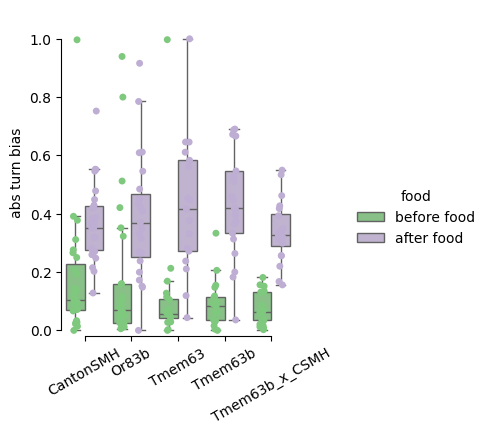

In [54]:
# compare turn bias before and after food
try: plotdf_pre = pd.read_csv(op.join(plotDir, 'absturnBias_beforefood.csv'))
except: print('precalculate turn bias for before and after food encounter')
try: plotdf_post = pd.read_csv(op.join(plotDir, 'absturnBias_afterfood.csv'))
except: print('precalculate turn bias for before and after food encounter')

plotdf_pre['food'] = 'before food'
plotdf_post['food'] = 'after food'
plotdf_all = pd.concat([plotdf_pre, plotdf_post])

plotdf_all.to_csv(op.join(plotDir, 'absturnBias_panel_forStatistic.csv'), index=False)  
plotdf = plotdf_all.groupby(['genotype','fly','food'])['abs_ifCW'].mean().reset_index()
g = sns.catplot(
    data=plotdf, x="genotype", y="abs_ifCW", hue="food",
    kind="box", dodge=True, fliersize=0, aspect=.9, height=4, palette='Accent', hue_order=['before food','after food']
)
g.map_dataframe(sns.stripplot, x="genotype", y="abs_ifCW", 
            hue="food", dodge=True, palette='Accent', hue_order=['before food','after food'])
g.set_axis_labels("", 'abs turn bias')
g.set_xticklabels(rotation=30)
g.set(ylim=(-0.02,1.1))
g.despine(trim=True)
g.savefig(op.join(plotDir, 'absturnBias_perfly_before-afterfood_FigS6L.pdf'), dpi=300)

In [55]:
stats_df = {'groupA': [], 'groupB': [], 'test': [], 'p-value': [], 'star':[]}
#print('Comparison before vs after food ===')
for genotype in plotdf['genotype'].unique():
    print(genotype)
    A, B = plotdf.loc[(plotdf.food == 'before food')&(plotdf.genotype == genotype)].abs_ifCW.values, plotdf.loc[(plotdf.food == 'after food')&(plotdf.genotype == genotype)].abs_ifCW.values
    _, pval = stats.ranksums(A,B)
    stats_df['groupA'].append(f'{genotype}, before')
    stats_df['groupB'].append(f'{genotype}, after')
    stats_df['test'].append('scipy.stats.ranksums')
    stats_df['p-value'].append(pval)
    stats_df['star'].append(pval2star(pval))
    
stats_df = pd.DataFrame(stats_df)
display(stats_df)
### save source data and stats
plotdf.to_csv(op.join(plotDir, f'sourcedata_FigS6L.csv'), index=False)
stats_df.to_csv(op.join(plotDir, f'stats_FigS6L.csv'), index=False)

CantonSMH
Or83b
Tmem63
Tmem63b
Tmem63b_x_CSMH


groupA                 groupB                  test  \
0       CantonSMH, before       CantonSMH, after  scipy.stats.ranksums   
1           Or83b, before           Or83b, after  scipy.stats.ranksums   
2          Tmem63, before          Tmem63, after  scipy.stats.ranksums   
3         Tmem63b, before         Tmem63b, after  scipy.stats.ranksums   
4  Tmem63b_x_CSMH, before  Tmem63b_x_CSMH, after  scipy.stats.ranksums   

        p-value star  
0  2.228190e-06  ***  
1  3.625430e-04  ***  
2  3.401856e-05  ***  
3  5.932108e-07  ***  
4  6.702103e-08  ***

<a id='fig-s6m'></a>
## Fig. S6M - Cumulative feeding as a function of loop number

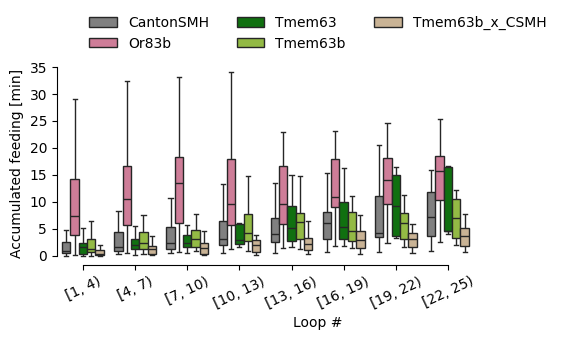

In [56]:
fig, ax = plt.subplots(1,1,figsize = (6,3.5))
mypal = cond_color

plotDf = loopLenStats.query(f'loopN < 25').reset_index()
plotDf['fedmin'] = plotDf.fed.values*1/60
g = sns.boxplot(x='loopN_binShort', y='fedmin', hue='genotype', showfliers = False, palette=pal, ax=ax, data=plotDf)
ax.set_ylabel('Accumulated feeding [min]')
ax.set_xlabel('Loop #')
ax.set_xticks(range(len(plotDf.loopN_binShort.unique()))) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 25);
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
sns.despine(ax=ax, trim=True)
fig.tight_layout()
fig.savefig(op.join(plotDir, 'cummunlativeFeeding_sensorySilencing_FigS6M.pdf'), dpi=300)

### Save preprocessed data to file

In [25]:
distDf.to_csv(plotDir+sep+'distDf_{}.csv'.format(groupName))
distDf_farClose.to_csv(plotDir+sep+'distDf_farClose_{}.csv'.format(groupName))
loopdepStats.to_csv(plotDir+sep+'loopStats_{}.csv'.format(groupName))
loopLenStats.to_csv(plotDir+sep+'loopLenStats_{}.csv'.format(groupName))

<a id='dataS1-fig-4a'></a>
## Data S1 Fig. 4A - Locomotion as function of time since last food

In [58]:
visitTH = '>=1' #  This is an upper bound: ==0 --> before finding food spot, >=1 --> after finding food.
if visitTH == '==0': postfix = 'beforefood'
else: postfix = 'afterfood'
    
gen = per_move_postfood_df.genotype.values
conds = per_move_postfood_df.condition.values
per_move_postfood_df['cond-gen'] = [f'{gen[t]}\n{conds[t]}' for t in range(len(gen))]

#itterate through genotypes to fetch correct data
per_move_postfood_df_filt = pd.DataFrame()
for g, genotype in enumerate(genotypes):
    querystring = f'seg_state in {[2,3,4,5]} & etho_state == {etho_state}  & genotype == "{genotype}"'
    querystring = querystring + f' & after_which_visit {visitTH}'
    per_move_postfood_df_filt = pd.concat([per_move_postfood_df_filt,per_move_postfood_df.query(querystring)])

timebins = np.round(np.linspace(-0.5,3.5,9),2)
per_move_postfood_df_filt['dist_since_visit_log'] = np.log10(per_move_postfood_df_filt.dist_since_visit.values)
per_move_postfood_df_filt['dist_since_visit_log10_bin'] = pd.cut(per_move_postfood_df_filt.dist_since_visit_log.values, bins=timebins, precision=1, labels=False)

/var/folders/_1/9_lwjkgx0cxdt5ckms78hbdm0000gr/T/ipykernel_62022/3344902793.py:17: RuntimeWarning: divide by zero encountered in log10
  per_move_postfood_df_filt['dist_since_visit_log'] = np.log10(per_move_postfood_df_filt.dist_since_visit.values)


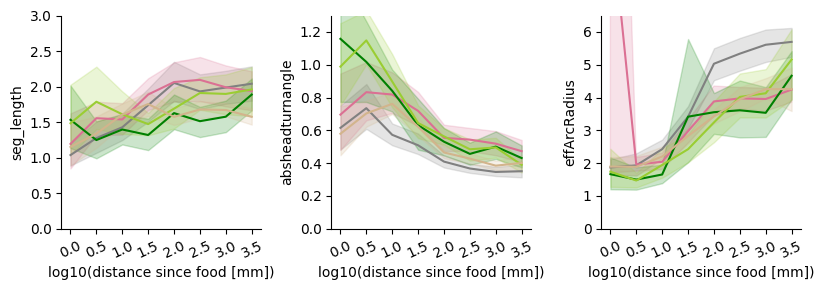

In [59]:
if postfix == 'afterfood':  #only makes sense after food
    pltdf = per_move_postfood_df_filt.groupby(['genotype','condition','cond-gen','flyid','dist_since_visit_log10_bin'],observed=False)[['seg_length','effArcRadius','absheadturnangle']].median().reset_index()
    
    qoi = ['seg_length','absheadturnangle','effArcRadius']
    ylims = [(0,3),(0,1.3),(0,6.5)]# #[(0,2.5),(0,1),(0,6.5)]# [(0.4,3),(0.2,1.5),(0,6.5)]#[(0.4,2.5),(0,6.5),(0.1,1.1)]

    fig, axs = plt.subplots(1,len(qoi),figsize=(2.75*len(qoi),3))

    for i, q in enumerate(qoi):
        ax = sns.lineplot(data = pltdf, x='dist_since_visit_log10_bin', y=q, hue='genotype', palette=pal, ax=axs[i])
        ax.set_xticks(np.arange(len(timebins)-1));
        ax.set_xticklabels(timebins[1:],rotation = 25);
        #if i!=2: 
        ax.legend('', frameon=False)
        myAxisTheme(ax)
        ax.set_ylim(ylims[i])
        ax.set_xlabel('log10(distance since food [mm])')
    fig.tight_layout()
    fig.savefig(op.join(plotDir, 'distsincefood_locomotion_DataS1-Fig4A.pdf'), dpi=300)

<a id='dataS1-fig-4b'></a>
## Data S1 Fig. 4B - Cumulative feeding over time

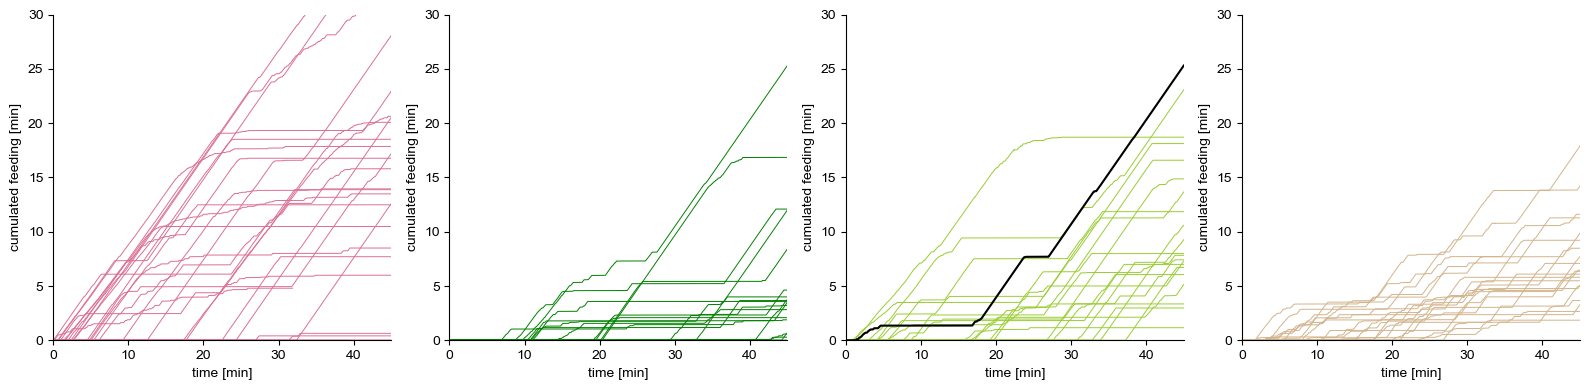

In [4]:
fig, axs = plt.subplots(1,len(genotypes)-1,figsize=(4*4,4))
for c, cond in enumerate(genotypes[1:]):
    tmp = datDf.query(f'genotype == "{cond}"')
    ax=axs[c]
    for fly in tmp.fly.unique():
        inds = np.where(tmp.query(f'fly == "{fly}"').dt.values < 0.05)[0]
        ax.plot(tmp.query(f'fly == "{fly}"').time.values[inds]/60, tmp.query(f'fly == "{fly}"').fed.values[inds]/60, color=pal[cond], linewidth=0.7)
    if c == 2:
        inds = np.where(tmp.query(f'flyid == "{flyID}"').dt.values < 0.05)[0]
        ax.plot(tmp.query(f'flyid == "{flyID}"').time.values[inds]/60, tmp.query(f'flyid == "{flyID}"').fed.values[inds]/60, color='k')
    ax.set_ylim(0,1800/60)
    ax.set_xlim(0,45)
    myAxisTheme(ax)
    ax.set_xlabel('time [min]')
    ax.set_ylabel('cumulated feeding [min]')
fig.tight_layout()
fig.savefig(op.join(plotDir, f'cumulativeFeeding_DataS1-Fig4B_exFly{flyID}.pdf'), dpi=300)

<a id='dataS1-fig-5'></a>
## Data S1 Fig. 5-7 - Example trajectories for Tmem63 mutants and heterozygote controls

In [ ]:
conditions = list(np.unique(datDf.condition.values))
for genotype in genotypes[2:]:
    print(genotype)
    cflies = datDf.query(f'genotype=="{genotype}"').flyid.unique()
    nflies = len(cflies)
    print(nflies)

    nrows = 4
    fig, axs = plt.subplots(nrows,int(np.ceil(nflies/nrows)),figsize=(3*np.ceil(nflies/nrows),3*nrows))

    for f, fly in enumerate(cflies):
        i = f%nrows
        j = int(f/nrows)
        flyDf = datDf.query(f'genotype=="{genotype}" & flyid=="{fly}"')
        
        try:
            firstFood = np.where(flyDf.segment.values == 1)[0][0]
        except IndexError:
            firstFood = -1
        axs[i,j].plot(flyDf.body_x.values[:firstFood], flyDf.body_y.values[:firstFood],color='k', alpha=0.4)
        axs[i,j].plot(flyDf.body_x.values[firstFood:], flyDf.body_y.values[firstFood:],color='maroon', alpha=0.4)
        plotArenaAndFood(axs[i,j], foodRad=flyDf.food_r.values[0], arenaRad=flyDf.arenaRad.values[0],foodCol='firebrick')
        axs[i,j].set_title(fly)
    for i in range(nrows):
        for ax in axs[i,:]: ax.axis('off')
    fig.tight_layout()

    fig.savefig(plotDir+sep+f'trajectoryIllustration_{genotype}_DataS1.pdf')